In [1]:
path_to_dodem = '/Users/jmdunca2/do-dem/'
from sys import path as sys_path
sys_path.append(path_to_dodem+'/dodem/')

import HARP_and_age as haa

import pickle
import importlib

import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u

In [2]:
with open('/Users/jmdunca2/do-dem/reference_files/all_targets_postghost.pickle', 'rb') as f:
    all_targets = pickle.load(f)

In [6]:
def get_same_region_file_lists(samesames, all_targets):

    #For the list of lists of region names, make a file list for every separate region
    filelist = []
    for s in samesames:
        ss_filelist=[]
        for ss in s:
            sks = all_targets[ss.split(' ')[0]]['sub_keys']
            for i in range(0, len(sks)):
                if sks[i] == ss:
                    ss_filelist.extend(all_targets[ss.split(' ')[0]]['res_file_dict(s)'][i]['quiet files all-inst'])
        filelist.append(ss_filelist)

    return filelist


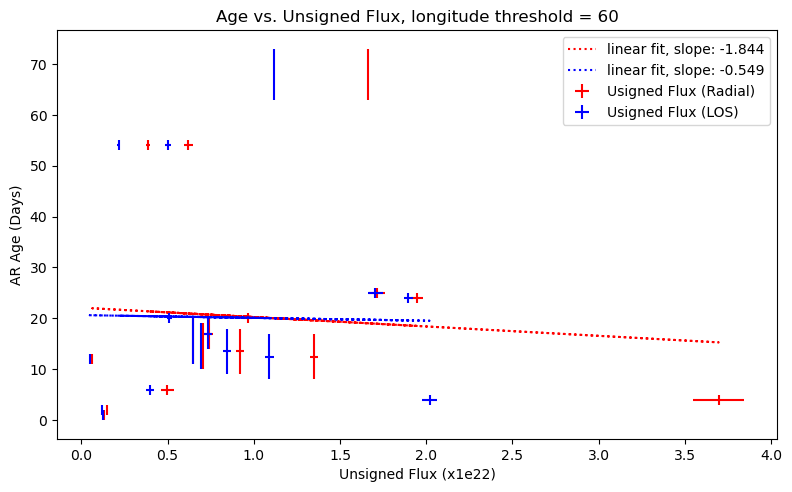

In [4]:
# #Unsigned flux vs. AGE

# ages, hparr, hparl, heli, regions = haa.fetch_age_and_usflux(all_targets, lonthresh=30)
# print('')
magparams = haa.fetch_age_and_usflux(all_targets, lonthresh=60)
print('')
# ages, hparr, hparl, heli, regions = haa.fetch_age_and_usflux(all_targets, lonthresh=45)


/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jmdunca2/do-dem//dodem/HARP_and_age.py:791: RuntimeWarning: invalid value

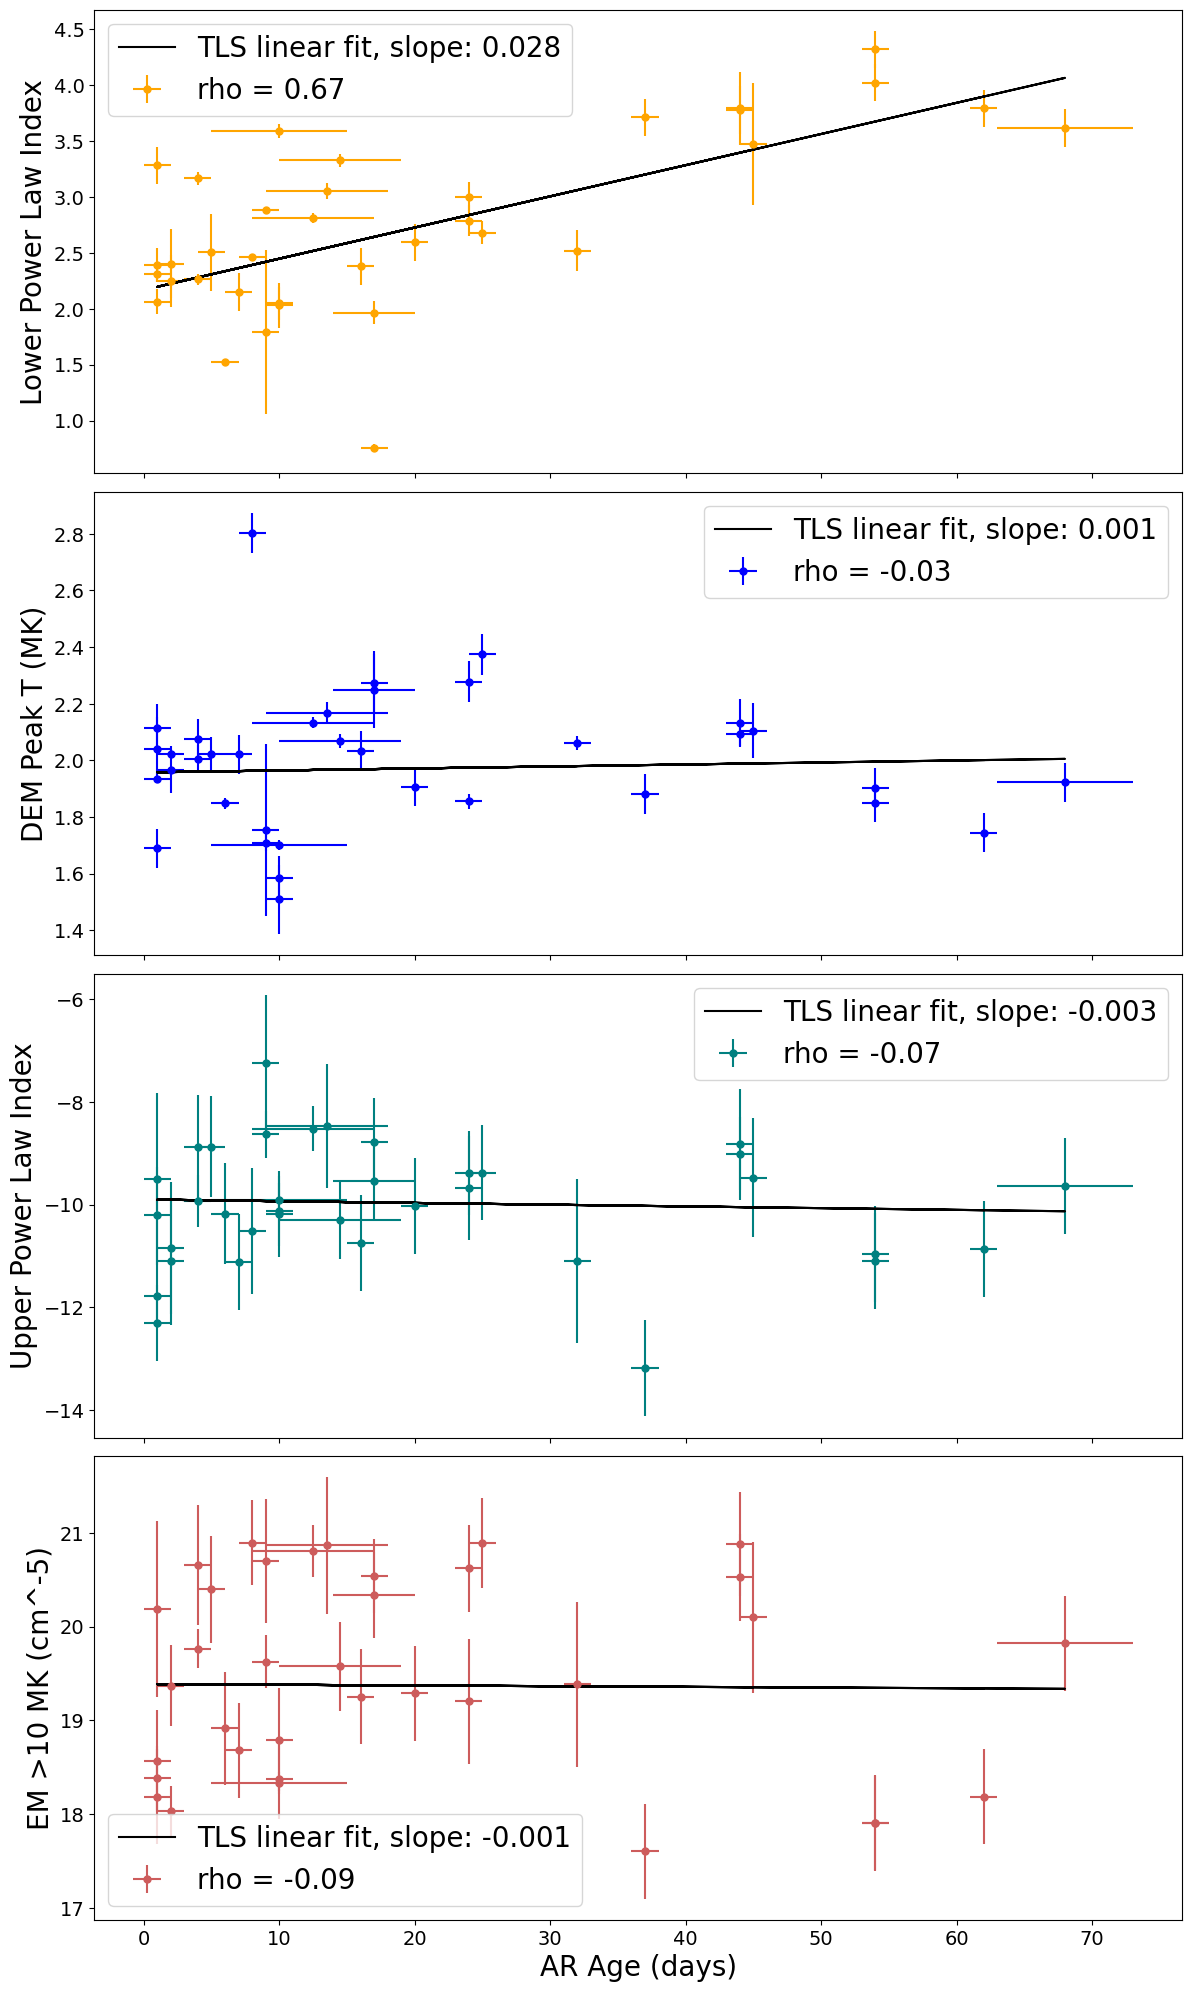

In [5]:
#MEGAPLOT - AREA NORMALIZED
importlib.reload(haa)

from scipy import odr

#ODR documentation: https://docs.scipy.org/doc/scipy-1.16.0/reference/odr.html

def f(B, x):
    #Linear function
    return B[0]*x + B[1]
    
linear = odr.Model(f)

params = ['lowerpower2', 'peak', 'upperpower2', 'above10']
paramlabels = ['Lower Power Law Index', 'DEM Peak T (MK)', 'Upper Power Law Index', 'EM >10 MK (cm^-5)']
tcolors = ['orange', 'blue', 'teal', 'indianred']
skh = [False, False, False, False]


labelsize=20

fig, axes = plt.subplots(len(params),1, figsize=(12, 5*len(params)), tight_layout = {'pad': 1}, sharex='col')

for i in range(0, len(params)):

    dataparam, ages, stdvs, sks = haa.get_ages_vs_params(all_targets, param=params[i], return_stdvs=True,
                                                skiphuh=skh[i])

    yerr_ = stdvs
    wwy = [1/y for y in yerr_]
    

    #Plot vs. age
    ax=axes[i]



    herr = ages[:,0]-ages[:,1]
    wwx = [1/y for y in herr]

    #[print(s) if (s not in sks) else print('') for s in regions]

    rho=round(np.corrcoef(ages[:,0], dataparam[:,0])[0,1],2)
    ax.errorbar(ages[:,0], dataparam[:,0], color=tcolors[i], yerr=yerr_, xerr=herr, 
                linestyle='none', marker='o', markersize=5, label='rho = '+str(rho))

    # #Fit option with y weights only
    # m, b = np.polyfit(ages[:,0], dataparam[:,0], 1, w=wwy)
    # fity = np.array(ages[:,0])*m + b
    # ax.plot(ages[:,0], fity, label='LS fit, slope: '+str(round(m,3)), color='grey')  

    #Fit option with both weights
    mydata = odr.Data(ages[:,0], dataparam[:,0], wd=wwx, we=wwy)
    myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
    myoutput = myodr.run()
    #myoutput.pprint()
    m, b = myoutput.beta
    fity = np.array(ages[:,0])*m + b
    ax.plot(ages[:,0], fity, label='TLS linear fit, slope: '+str(round(m,3)), color='black')


    if i==len(params)-1:
        ax.set_xlabel('AR Age (days)', fontsize=labelsize)
    ax.set_ylabel(paramlabels[i], fontsize=labelsize)
    ax.legend(fontsize=labelsize)
    ax.tick_params(axis='both', which='major', labelsize=14) 


plt.savefig('all_DEM_params_vs_age_postacc.png')

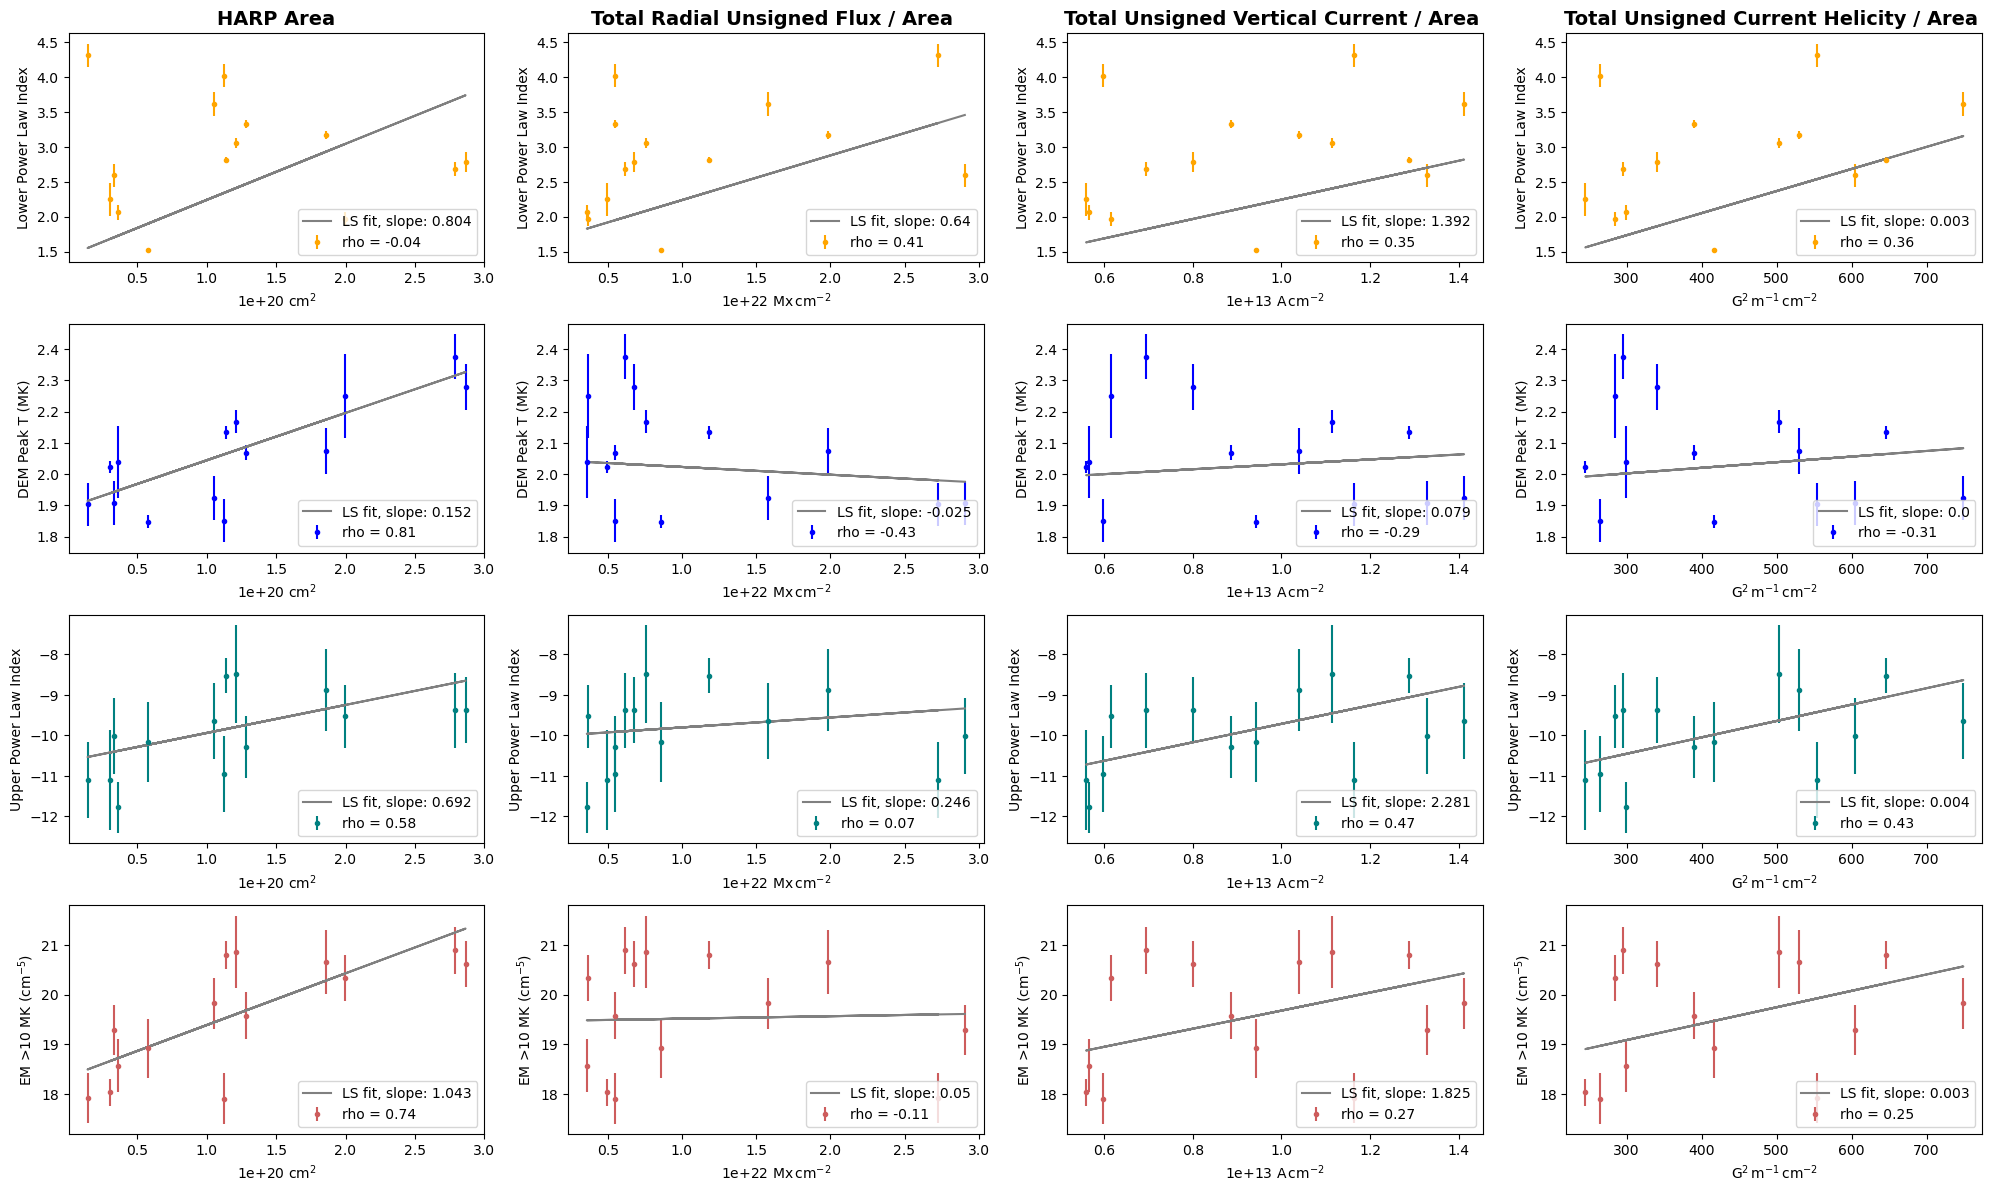

In [6]:
#MEGAPLOT - NICE VERSION
#We do want to normalize other parameters by HARP area, and also add a plot vs. HARP area. 
importlib.reload(haa)

params = ['lowerpower2', 'peak', 'upperpower2', 'above10']
paramlabels = ['Lower Power Law Index', 'DEM Peak T (MK)', 'Upper Power Law Index', 'EM >10 MK ('+(u.cm**(-5)).to_string('latex_inline')+')']
tcolors = ['orange', 'blue', 'teal', 'indianred']
skh = [False, False, False, False]

mparams = ['areas', 'usflx', 'tuvc', 'tuheli'] #'mheli',
normcheck = [False, True, True, True]

magparams = haa.fetch_age_and_usflux(all_targets, lonthresh=60, plot=False, check_quiet=True)

regions = magparams['regions']['vals']

fig, axes = plt.subplots(len(params),len(mparams), figsize=(5*len(mparams), 3*len(params)), tight_layout = {'pad': 1})

for i in range(0, len(params)):
    for j in range(0, len(mparams)):

        dataparam, ages, stdvs, sks = haa.get_ages_vs_params(all_targets, param=params[i], return_stdvs=True,
                                                    skiphuh=skh[i])

        #Get indices of regions that are within the longitude threshold (to plot DEM params vs HARP params)
        trs = np.where(np.array([1 if s in regions else 0 for s in sks]) == 1)[0]
        yerr_ = stdvs[trs]
        wwy = [1/y for y in yerr_]
        

        #Plot vs. radial unsigned flux.
        ax=axes[i,j]
        magpar=magparams[mparams[j]]['vals']
        if normcheck[j]:
            norm=magparams[mparams[j]]['norm']*(magparams['areas']['vals'][:,0]/1e20)
        else:
            norm=magparams[mparams[j]]['norm']

        herr = magpar[:,1]/norm 
        wwx = [1/y for y in herr]
    
        #[print(s) if (s not in sks) else print('') for s in regions]
        rho=round(np.corrcoef(magpar[:,0]/norm, dataparam[trs,0])[0,1],2)
    
        ax.errorbar(magpar[:,0]/norm, dataparam[trs,0], color=tcolors[i], yerr=yerr_, #xerr=herr, 
                    linestyle='none', marker='o', markersize=3, label='rho = '+str(rho))

        # #Fit option with y weights only
        m, b = np.polyfit(magpar[:,0]/norm, dataparam[trs,0], 1, w=wwy)
        fity = np.array(magpar[:,0]/norm)*m + b
        ax.plot(magpar[:,0]/norm, fity, label='LS fit, slope: '+str(round(m,3)), color='grey')  

        
        fsz=14
        fw='bold'
        if normcheck[j]:
            normunit = magparams[mparams[j]]['unit']/magparams['areas']['unit']
            
            if magparams[mparams[j]]['norm'] != 1:
                #ax.set_xlabel(magparams[mparams[j]]['name']+'/ HARP Area ('+"{:.0e}".format(magparams[mparams[j]]['norm'])+' '+normunit.to_string('latex_inline')+')')
                ax.set_xlabel("{:.0e}".format(magparams[mparams[j]]['norm'])+' '+normunit.to_string('latex_inline'))
                if i==0:
                    ax.set_title(magparams[mparams[j]]['name']+' / Area ', fontweight=fw, fontsize=fsz)
            else:
                #ax.set_xlabel(magparams[mparams[j]]['name']+'/ HARP Area ('+normunit.to_string('latex_inline')+')')
                ax.set_xlabel(normunit.to_string('latex_inline'))
                if i==0:
                    ax.set_title(magparams[mparams[j]]['name']+' / Area ', fontweight=fw, fontsize=fsz)
        else:
            if magparams[mparams[j]]['norm'] != 1:
                #ax.set_xlabel(magparams[mparams[j]]['name']+' ('+"{:.0e}".format(magparams[mparams[j]]['norm'])+' '+magparams[mparams[j]]['unit'].to_string('latex_inline')+')')
                ax.set_xlabel("{:.0e}".format(magparams[mparams[j]]['norm'])+' '+magparams[mparams[j]]['unit'].to_string('latex_inline'))
                if i==0:
                    ax.set_title(magparams[mparams[j]]['name'], fontweight=fw, fontsize=fsz)
            else:
                #ax.set_xlabel(magparams[mparams[j]]['name']+' ('+magparams[mparams[j]]['unit'].to_string('latex_inline')+')')
                ax.set_xlabel(magparams[mparams[j]]['unit'].to_string('latex_inline'))
                if i==0:
                    ax.set_title(magparams[mparams[j]]['name'], fontweight=fw, fontsize=fsz)
            
        ax.set_ylabel(paramlabels[i])
        ax.legend(loc='lower right')


plt.savefig('all_mag_params_area_normalized_postacc.png')

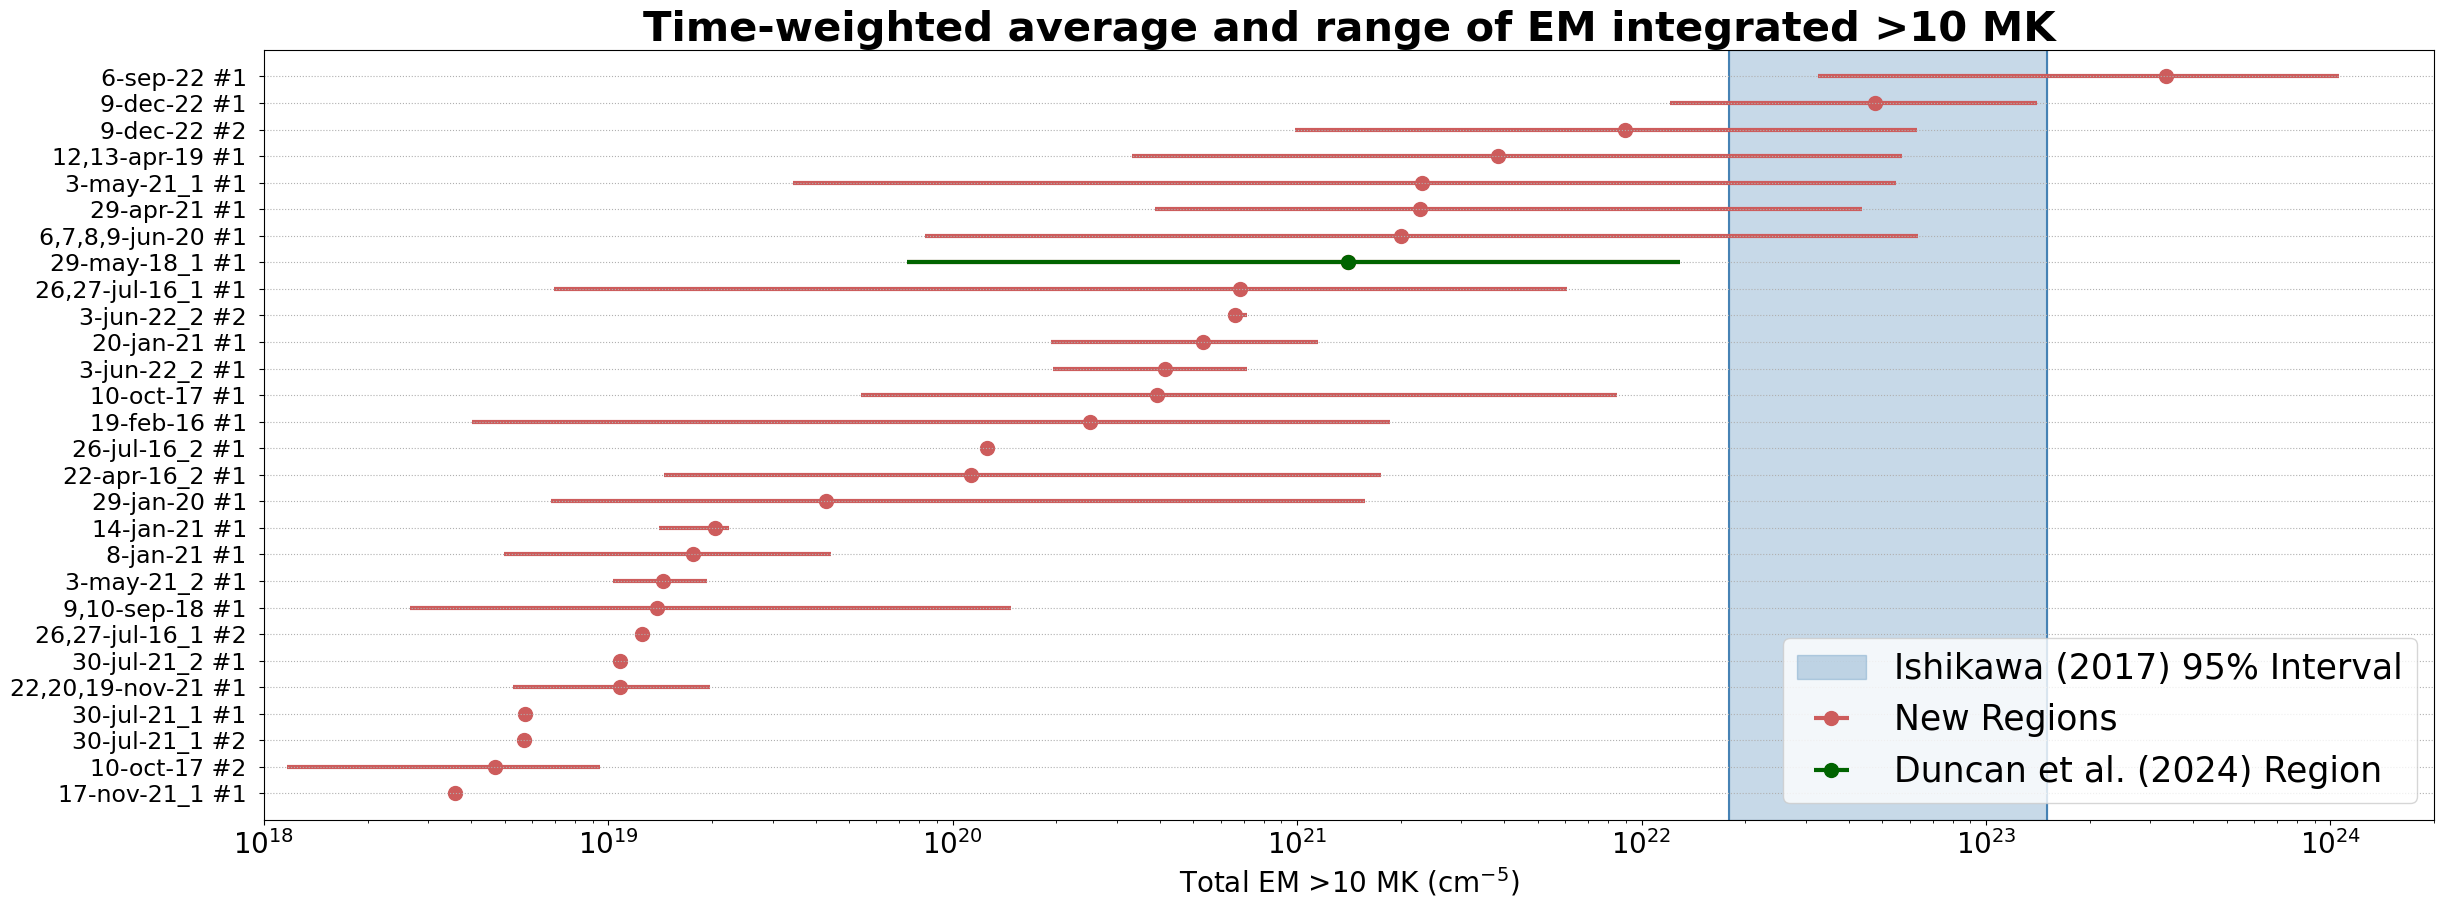

In [17]:
#Make EM > 10 MK plot

with open('/Users/jmdunca2/do-dem/reference_files/samesames.pickle', 'rb') as f:
    data = pickle.load(f)

samesames = data['same region lists']
filelist = get_same_region_file_lists(samesames, all_targets)


#Factor to adjust integrated EM values
area_i = 100**2
area_m = np.pi*150**2
#print(area_i, area_m)
factor = area_m/area_i



allgood=0
region_above10s=[]
region_totaltime=[]
for i in range(0, len(filelist)):
    gf = filelist[i]

    vals = []
    above10s_ = []
    totaltime = 0
    for f_ in gf:
        with open(f_, 'rb') as f:
            data = pickle.load(f)
        time = data['time_interval']
        dur = (time[1]-time[0]).to(u.s).value
        above10s = data['above_10MK']
        above10s_.append(above10s[0])
        vals.append([dur*above10s[0]])
        totaltime+=dur

    #print(totaltime)
    if vals:
        region_above10s.append([np.sum(vals)/totaltime*factor, np.min(above10s_)*factor, np.max(above10s_)*factor])
        region_totaltime.append(totaltime)

    else:
        region_above10s.append([0, 0, 0])
        region_totaltime.append(0)
    

order = np.argsort(np.array(region_above10s)[:,0])
regids = [samesames[i] for i in order]


labs=[]
for r in regids:
    lab=''
    first=0
    for ss in r:
        if first == 0:
            if ss[0] == '0':
                lab=lab+ss[1:-8]+'#'+str(int(ss[-1])+1)+' '
            else: 
                lab=lab+ss[0:-8]+'#'+str(int(ss[-1])+1)+' '
            first=1
        else:
            if ss[0] == '0':
                lab=ss[1:2]+','+lab
            else:    
                lab=ss[0:2]+','+lab

    labs.append(lab)

#print('')
#print(labs)

region_time_hr = np.array((region_totaltime*u.s).to(u.hr))
#print(region_time_hr[order])


fig, ax = plt.subplots(1, 1, figsize=(28,10))


xerr = [(np.array(region_above10s)[:,0][order] - np.array(region_above10s)[:,1][order]), 
        (np.array(region_above10s)[:,2][order] - np.array(region_above10s)[:,0][order])]

#print(xerr)


ax.errorbar(np.array(region_above10s)[:,0][order], np.arange(0, len(filelist), 1), 
            xerr=xerr,
           linestyle='', marker='o', linewidth=3, markersize=10, color='indianred', label='New Regions', zorder=1)

oneerr = np.zeros((2,1))

gind=20
oneerr[0] = xerr[0][gind]
oneerr[1] = xerr[1][gind]

ax.errorbar(np.array(region_above10s)[:,0][order][gind], np.arange(0, len(filelist), 1)[gind],
            xerr=oneerr,
            linestyle='', marker='o', color='darkgreen', linewidth=3, markersize=10, label='Duncan et al. (2024) Region', zorder=2) #, s=140)

fntsz=25
ax.set_xscale('log')
ax.axvline(1.8e22, color='steelblue', zorder=0)
ax.axvline(1.5e23, color='steelblue', zorder=0)
ax.axvspan(1.8e22, 1.5e23, alpha=0.3, color='steelblue', label='Ishikawa (2017) 95% Interval', zorder=0)
ax.set_yticks(np.arange(0, len(filelist))) #[2:]
ax.set_yticklabels(labels=labs, fontsize=17) #[2:]
plt.xticks(fontsize=20)
ax.set_xlabel('Total EM >10 MK ('+(u.cm**(-5)).to_string('latex_inline')+')', fontsize=20)
ax.grid(axis = 'y', linestyle='dotted')
ax.legend(loc='lower right', fontsize=fntsz)
ax.set_ylim([-1,len(filelist)])
ax.set_xlim([1e18,2e24])
ax.set_title('Time-weighted average and range of EM integrated >10 MK', fontsize=30, fontweight='bold')
print('')

plt.savefig('per_region_above10_new_postghost.png')

/Users/jmdunca2/do-dem/DEM_folders//initial_dem_6sep22//17-39-45_17-40-15/17-39-45_17-40-15_5.6_7.2_06-sep-22_MC_DEM_result.pickle


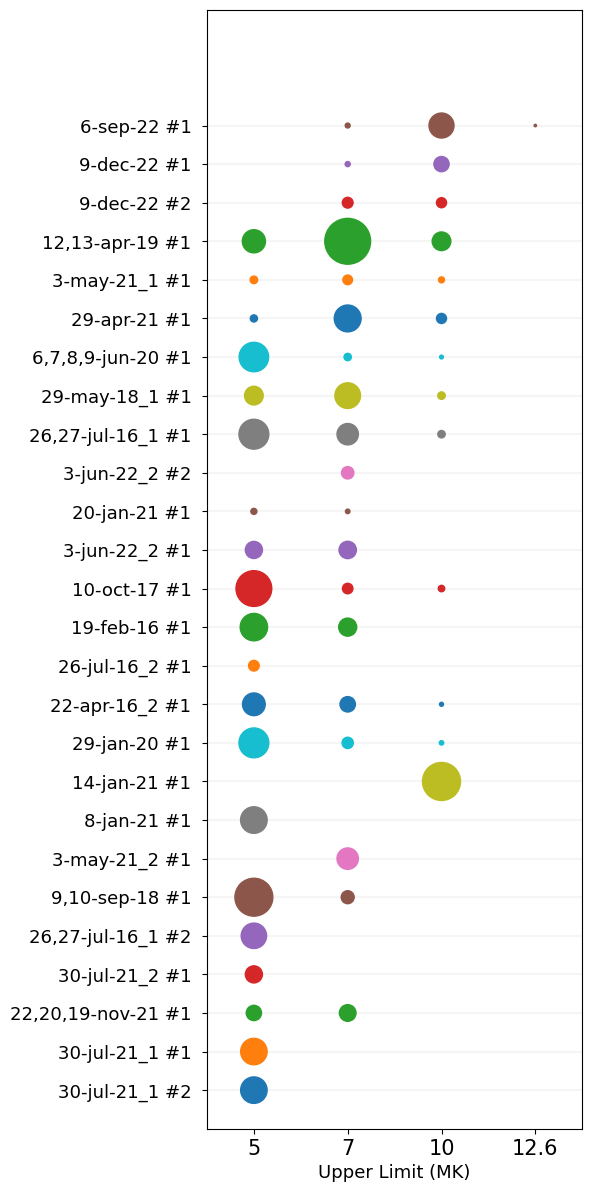

In [13]:
#Consistency plot

import glob
import os
import visualize_dem_results as viz

time_weighted = True
seconds_per = 1

tickfont=15

with open('/Users/jmdunca2/do-dem/reference_files/samesames.pickle', 'rb') as f:
    data = pickle.load(f)

samesames = data['same region lists']
filelist = get_same_region_file_lists(samesames, all_targets)

all_sumcons = []
for i in range(0, len(samesames)):
    key = samesames[i][0].split(' ')[0]
    sumcons_tw=[]
    for ff in filelist[i]:
        files = glob.glob(os.path.dirname(ff)+'/*'+key+'_MC_DEM_result.pickle')
        if len(samesames[i]) > 1:
            #print(samesames[i])
            key2 = samesames[i][1].split(' ')[0]
            files.extend(glob.glob(os.path.dirname(ff)+'/*'+key2+'_MC_DEM_result.pickle'))
                         
        files.sort()
        sumcon = 0.5
        for f in files:
            data, timestring, time = viz.load_DEM(f)
        
            sumcon += (1 if viz.checkresid(data) == 0 else 0)
        if time_weighted:
            dur = (time[1]-time[0]).to(u.s)
            time_mult = round(dur.value/seconds_per)
            sumcons_tw.extend([sumcon for i in range(0,time_mult)])
        if sumcon > 2.5:
            print(files[-1])
                

    all_sumcons.append(sumcons_tw)
    if not sumcons_tw:
        print('NO FILES FOR: ', samesames[i])



regids = [samesames[i] for i in order]
sumcons_order = [all_sumcons[i] for i in order]



fig, axes = plt.subplots(1, 1, figsize=(6,12), tight_layout = {'pad': 1})

yvs=[]
for i in range(0, len(regids[2:])):
    sizes = np.histogram(sumcons_order[2:][i], bins=[0.5,1.5,2.5,3.5, 4.5, 5.5, 6.5])[0]/10.
    yvs.append(i)
    axes.scatter(np.array([0.5,1.5,2.5,3.5, 4.5, 5.5])+0.5, np.zeros(6)+(i), s=sizes, zorder=3)
    axes.axhline(i, color='whitesmoke')


axes.set_xticks([1,2,3,4], ['5', '7', '10', '12.6'], fontsize=tickfont)
axes.set_xlabel('Upper Limit (MK)', fontsize=13)
axes.set_xlim([0.5,4.5])
    
axes.set_yticks(yvs)
axes.set_yticklabels(labels=labs[2:], fontsize=13)
axes.set_ylim([-1,28])

plt.savefig('consistency_bubbles_postghost.png')


# fig, axes = plt.subplots(len(regids[2:])+1, 1, figsize=(4,(len(regids[2:])+1)), sharex=True)

# for i in range(0, len(regids[2:])):
#     ax=axes[i]
#     ax.hist(sumcons_order[2:][i], bins=[0.5,1.5,2.5,3.5, 4.5, 5.5], edgecolor='black', color='palevioletred')
#     #ax.set_ylabel(ylabel)   
#     ax.set_xlim([0, 6.5])
#     ax.set_ylim([1, 1e5])
#     ax.set_yscale('log')
#     ax.text(3, 2e4, labs[2:][i], fontweight='bold')
#     #ax.set_xlabel('Upper Limit (MK)', fontsize=15)

# ax=axes[-1]
# ax.set_xticks([1,2,3,4], ['5', '7', '10', '12.6'], fontsize=tickfont)

# fig.subplots_adjust(hspace=0)

In [158]:
np.histogram(sumcons_order[2:][i], bins=[0.5,1.5,2.5,3.5, 4.5, 5.5])

(array([1540, 5635, 4245,    0,    0]), array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]))

In [164]:
sizes = np.histogram(sumcons_order[2:][i], bins=[0.5,1.5,2.5,3.5, 4.5, 5.5])[0]
print(type(sizes))

<class 'numpy.ndarray'>


Below: draft versions and other explorations. 

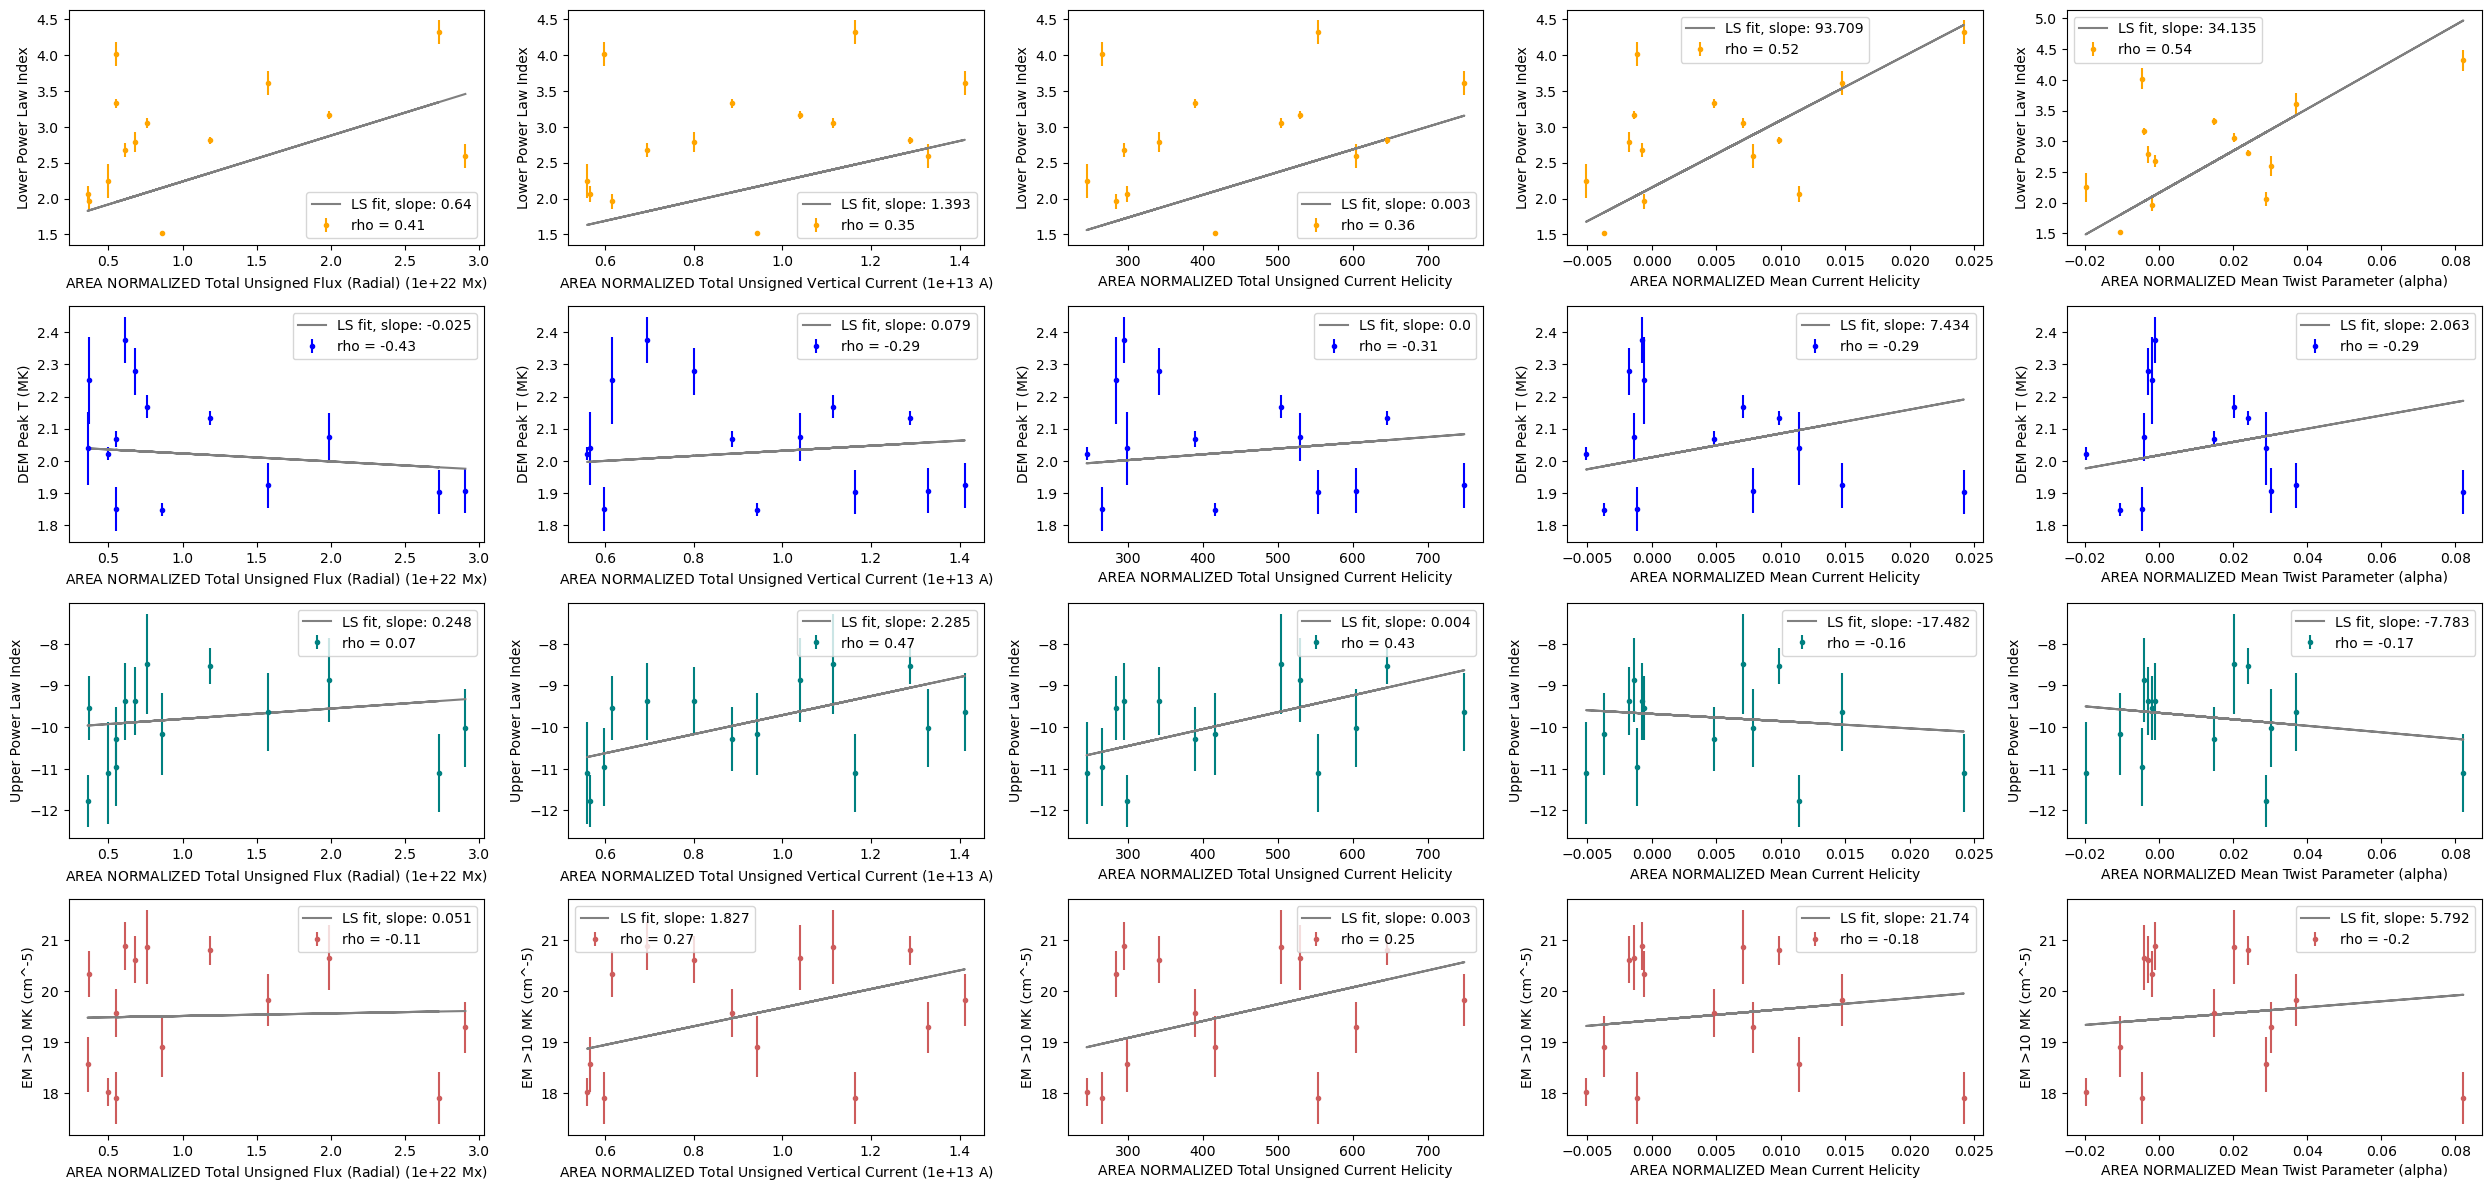

In [23]:
#MEGAPLOT - AREA NORMALIZED
importlib.reload(haa)

params = ['lowerpower2', 'peak', 'upperpower2', 'above10']
paramlabels = ['Lower Power Law Index', 'DEM Peak T (MK)', 'Upper Power Law Index', 'EM >10 MK (cm^-5)']
tcolors = ['orange', 'blue', 'teal', 'indianred']
skh = [False, False, False, False]

mparams = ['usflx', 'tuvc', 'tuheli', 'mheli', 'malp']

magparams = haa.fetch_age_and_usflux(all_targets, lonthresh=60, plot=False, check_quiet=True)

regions = magparams['regions']['vals']

fig, axes = plt.subplots(len(params),len(mparams), figsize=(5*len(mparams), 3*len(params)), tight_layout = {'pad': 1})

for i in range(0, len(params)):
    for j in range(0, len(mparams)):

        dataparam, ages, stdvs, sks = haa.get_ages_vs_params(all_targets, param=params[i], return_stdvs=True,
                                                    skiphuh=skh[i])

        #Get indices of regions that are within the longitude threshold (to plot DEM params vs HARP params)
        trs = np.where(np.array([1 if s in regions else 0 for s in sks]) == 1)[0]
        yerr_ = stdvs[trs]
        wwy = [1/y for y in yerr_]
        

        #Plot vs. radial unsigned flux.
        ax=axes[i,j]
        magpar=magparams[mparams[j]]['vals']
        norm=magparams[mparams[j]]['norm']*(magparams['areas']['vals'][:,0]/1e20)

        herr = magpar[:,1]/norm 
        wwx = [1/y for y in herr]
    
        #[print(s) if (s not in sks) else print('') for s in regions]
        rho=round(np.corrcoef(magpar[:,0]/norm, dataparam[trs,0])[0,1],2)
    
        ax.errorbar(magpar[:,0]/norm, dataparam[trs,0], color=tcolors[i], yerr=yerr_, #xerr=herr, 
                    linestyle='none', marker='o', markersize=3, label='rho = '+str(rho))

        # #Fit option with y weights only
        m, b = np.polyfit(magpar[:,0]/norm, dataparam[trs,0], 1, w=wwy)
        fity = np.array(magpar[:,0]/norm)*m + b
        ax.plot(magpar[:,0]/norm, fity, label='LS fit, slope: '+str(round(m,3)), color='grey')  


        
        if magparams[mparams[j]]['norm'] != 1:
            ax.set_xlabel('AREA NORMALIZED '+magparams[mparams[j]]['name']+' ('+"{:.0e}".format(magparams[mparams[j]]['norm'])+' '+magparams[mparams[j]]['unit'].to_string('latex')+')')
        else:
            ax.set_xlabel('AREA NORMALIZED '+magparams[mparams[j]]['name'])
        ax.set_ylabel(paramlabels[i])
        ax.legend()


plt.savefig('all_mag_params_area_normalized_postacc.png')

In [22]:
from astropy import units as u
q=1e20*(u.cm)**2

print(f"{q:latex}")

$1 \times 10^{20} \; \mathrm{cm^{2}}$


/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jmdunca2/do-dem//dodem/HARP_and_age.py:647: RuntimeWarning: invalid value

Top panels: all regions
Bottom panels: no 12-sep-17, 13-sep-17, 03-may-21_1, 03-may-21_2 (fit issues)


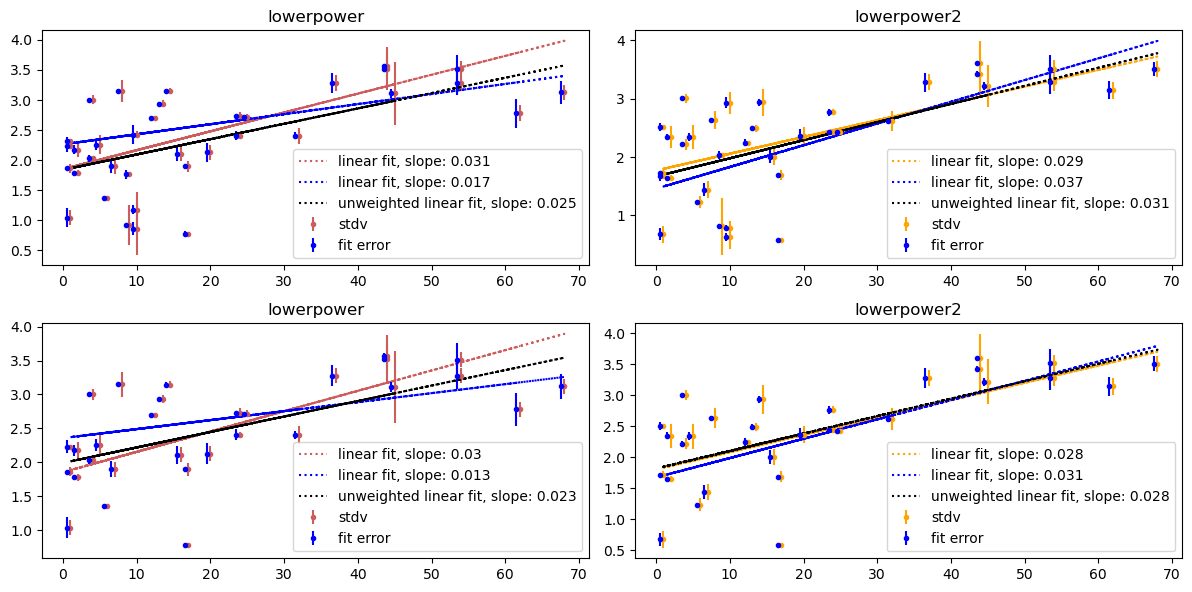

In [4]:
"""
Let's look more at some POWERLAWS - what do we get with the AIA-only DEM results? Looks like we replicate a similar 
relationship (good sanity check). 

"""

fig, axes = plt.subplots(2,2, figsize=(12, 6), tight_layout = {'pad': 1})


params = ['lowerpower', 'lowerpower2', 'lowerpower', 'lowerpower2']
         #'upperpower2', 'lowerpower2']
tcolors = ['indianred', 'orange', 'indianred', 'orange']
skh = [False, False, True, True]

i=1

for i in range(0, len(params)):

    dataparam, ages, stdvs, sks = haa.get_ages_vs_params(all_targets, param=params[i], 
                                                     return_stdvs=True, filetype='quiet files onlyaia',
                                                    skiphuh=skh[i])  
    
    #print(dataparam.shape)
    #print(dataparam)
    #print(ages)
    #print(stdvs)
    
    
    
    ax=axes[(i//2),(i%2)]
    
    yerr_ = stdvs
    #print(yerr_)
    yerr1=yerr_

    #Trying to keep the stdv-weighted fit from being tugged away from the rest of the values by cases with only a few measurements
    ww = [1/y if y > 0.02 else 0.1*np.mean(yerr_) for y in yerr_]
    #print(ww)
    
    ax.errorbar(ages[:,0], dataparam[:,0], color=tcolors[i], yerr=yerr_, linestyle='none', marker='o', markersize=3, label='stdv')
    m, b = np.polyfit(ages[:,0], dataparam[:,0], 1, w=ww)
    fity = np.array(ages[:,0])*m + b
    ax.plot(ages[:,0], fity, linestyle='dotted', label='linear fit, slope: '+str(round(m,3)), color=tcolors[i])
    
    yerr_ = dataparam[:,1]
    #print('fit error > stdv: ', len(np.where(yerr_/yerr1 > 1.)[0]), len(yerr_))
    #ww = [1/y if y != 0 else np.mean(yerr_)/10 for y in yerr_]
    
    ax.errorbar(ages[:,0]-0.5, dataparam[:,0], color='blue', yerr=yerr_, linestyle='none', marker='o', markersize=3, label='fit error')
    m, b = np.polyfit(ages[:,0], dataparam[:,0], 1, w=1/yerr_)
    fity = np.array(ages[:,0])*m + b
    ax.plot(ages[:,0], fity, linestyle='dotted', label='linear fit, slope: '+str(round(m,3)), color='blue')

    m, b = np.polyfit(ages[:,0], dataparam[:,0], 1)
    fity = np.array(ages[:,0])*m + b
    ax.plot(ages[:,0], fity, linestyle='dotted', label='unweighted linear fit, slope: '+str(round(m,3)), color='black')
    
    ax.set_title(params[i])
    ax.legend(loc='lower right')


print('Top panels: all regions')
print('Bottom panels: no 12-sep-17, 13-sep-17, 03-may-21_1, 03-may-21_2 (fit issues)')

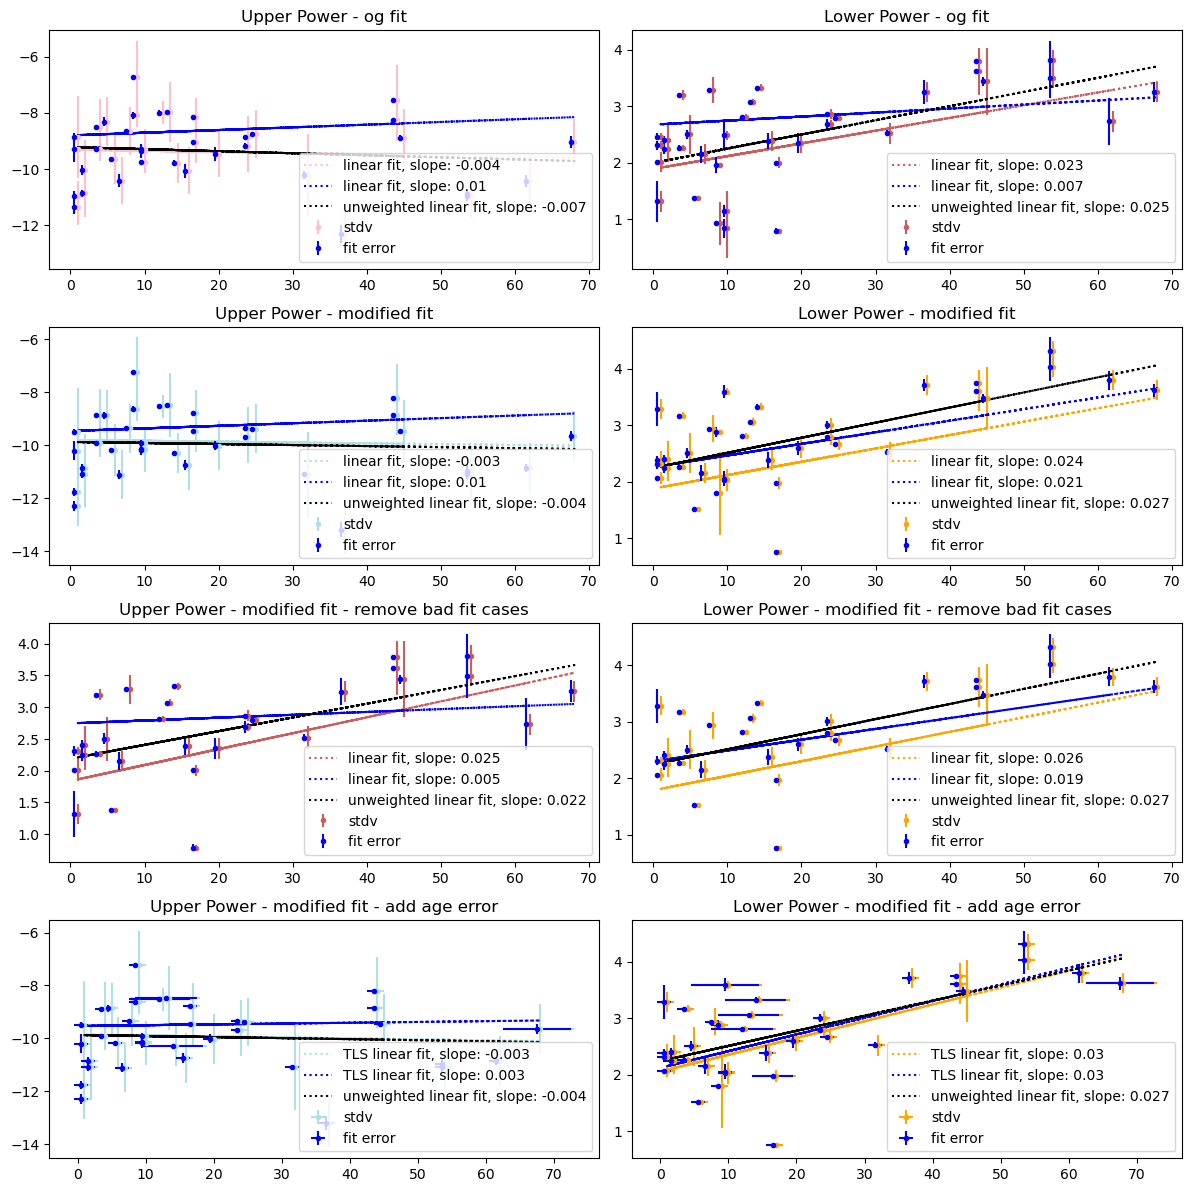

In [5]:
"""
Investigating various options for plotting/fitting/uncertainties, etc. for DEM power laws for the "all instrument"
(e.g. at least NuSTAR+AIA, sometimes with XRT) DEM results at quiet times. 

The conclusion for now is that we will use:

Lower Power Law:

-Modified fit method (upper boundary is index of DEM max + 1 - not fixed value)
-STDV of results from different time intervals as uncertainty. For cases with fewer than three time intervals, use the mean of all the 
    other (>3 measurement) cases.
-Linear trend fit uses both age and power law uncertainties. 

Upper Power Law:

-Modified fit method (upper boundary is temp. closest to logT=6.35 + 3 temp bin. - not + 1 temp bin)
-STDV of results from different time intervals as uncertainty. For cases with fewer than three time intervals, use the mean of all the 
    other (>3 measurement) cases.
-Linear trend fit uses both age and power law uncertainties. 
"""

fig, axes = plt.subplots(4,2, figsize=(12, 12), tight_layout = {'pad': 1})


params = [ 'upperpower', 'lowerpower',
         'upperpower2', 'lowerpower2',
         'lowerpower', 'lowerpower2']
tcolors = ['pink', 'indianred', 'powderblue', 'orange', 'indianred', 'orange']
skh = [False, False, False, False, True, True]

titles = ['Upper Power - og fit', 'Lower Power - og fit', 'Upper Power - modified fit', 'Lower Power - modified fit',
          'Upper Power - modified fit - remove bad fit cases', 'Lower Power - modified fit - remove bad fit cases',
          'Upper Power - modified fit - add age error', 'Lower Power - modified fit - add age error']



for i in range(0, len(params)):

    dataparam, ages, stdvs, sks = haa.get_ages_vs_params(all_targets, param=params[i], return_stdvs=True,
                                                    skiphuh=skh[i])  
    
    #print(dataparam.shape)
    #print(ages)
    #print(stdvs)
    
    
    
    ax=axes[(i//2),(i%2)]
    
    yerr_ = stdvs
    #print(yerr_)

    #Trying to keep the stdv-weighted fit from being tugged away from the rest of the values by cases with only a few measurements
    ww = [1/y if y > 0.02 else 1/np.mean(yerr_) for y in yerr_]
    #print(ww)
    
    ax.errorbar(ages[:,0], dataparam[:,0], color=tcolors[i], yerr=yerr_, linestyle='none', marker='o', markersize=3, label='stdv')
    m, b = np.polyfit(ages[:,0], dataparam[:,0], 1, w=ww)
    fity = np.array(ages[:,0])*m + b
    ax.plot(ages[:,0], fity, linestyle='dotted', label='linear fit, slope: '+str(round(m,3)), color=tcolors[i])
    
    yerr_ = dataparam[:,1]
    #ww = [1/y if y != 0 else np.mean(yerr_)/10 for y in yerr_]
    
    ax.errorbar(ages[:,0]-0.5, dataparam[:,0], color='blue', yerr=yerr_, linestyle='none', marker='o', markersize=3, label='fit error')
    m, b = np.polyfit(ages[:,0], dataparam[:,0], 1, w=1/yerr_)
    #print(m,b)
    fity = np.array(ages[:,0])*m + b
    ax.plot(ages[:,0], fity, linestyle='dotted', label='linear fit, slope: '+str(round(m,3)), color='blue')

    m, b = np.polyfit(ages[:,0], dataparam[:,0], 1)
    fity = np.array(ages[:,0])*m + b
    ax.plot(ages[:,0], fity, linestyle='dotted', label='unweighted linear fit, slope: '+str(round(m,3)), color='black')
    
    ax.set_title(titles[i])
    ax.legend(loc='lower right')


from scipy import odr

#ODR documentation: https://docs.scipy.org/doc/scipy-1.16.0/reference/odr.html

def f(B, x):
    #Linear function
    return B[0]*x + B[1]
    
linear = odr.Model(f)


params = ['upperpower2', 'lowerpower2']
tcolors = ['powderblue', 'orange']
skh = [False, False]

for i in range(0, len(params)):

    dataparam, ages, stdvs, sks = haa.get_ages_vs_params(all_targets, param=params[i], return_stdvs=True,
                                                    skiphuh=skh[i])  

    
    ax=axes[3,(i%2)]
    
    yerr_ = stdvs
    ageerr = ages[:,0]-ages[:,1]
    #print(ageerr)
    
    #print(yerr_)

    #Trying to keep the stdv-weighted fit from being tugged away from the rest of the values by cases with only a few measurements
    wwy = [1/y if y > 0.02 else np.mean(yerr_) for y in yerr_]
    wwx = [1/y for y in ageerr]
    #print(wwy)
    #print(wwx)
    
    
    ax.errorbar(ages[:,0], dataparam[:,0], color=tcolors[i], yerr=yerr_, xerr=ageerr, 
                linestyle='none', marker='o', markersize=3, label='stdv')

    mydata = odr.Data(ages[:,0], dataparam[:,0], wd=wwx, we=wwy)
    myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
    myoutput = myodr.run()
    #myoutput.pprint()
    m, b = myoutput.beta
    fity = np.array(ages[:,0])*m + b
    ax.plot(ages[:,0], fity, linestyle='dotted', label='TLS linear fit, slope: '+str(round(m,3)), color=tcolors[i])
    
    # m, b = np.polyfit(ages[:,0], dataparam[:,0], 1, w=ww)
    # fity = np.array(ages[:,0])*m + b
    # ax.plot(ages[:,0], fity, linestyle='dotted', label='linear fit, slope: '+str(round(m,3)), color=tcolors[i])
    
    yerr_ = dataparam[:,1]
    
    ax.errorbar(ages[:,0]-0.5, dataparam[:,0], color='blue', yerr=yerr_, xerr=ageerr,
                linestyle='none', marker='o', markersize=3, label='fit error')
    
    mydata = odr.Data(ages[:,0], dataparam[:,0], wd=wwx, we=1/yerr_)
    myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
    myoutput = myodr.run()
    #myoutput.pprint()
    m, b = myoutput.beta
    fity = np.array(ages[:,0])*m + b
    ax.plot(ages[:,0], fity, linestyle='dotted', label='TLS linear fit, slope: '+str(round(m,3)), color='blue')

    m, b = np.polyfit(ages[:,0], dataparam[:,0], 1)
    fity = np.array(ages[:,0])*m + b
    ax.plot(ages[:,0], fity, linestyle='dotted', label='unweighted linear fit, slope: '+str(round(m,3)), color='black')
    
    ax.set_title(titles[6+i])
    ax.legend(loc='lower right') 



# ax=axes[2,0]



# dataparam, ages, stdvs, sks = get_ages_vs_params(all_targets, param='lowerpower', return_stdvs=True)
# dataparam2, ages, stdvs2, sks = get_ages_vs_params(all_targets, param='lowerpower2', return_stdvs=True)

# ax.scatter(ages[:,0], dataparam[:,0], color='green')
# ax.scatter(ages[:,0], dataparam2[:,0], color='springgreen')

# print('')
# print('')

# #print(np.mean(dataparam[:,0]), np.mean(dataparam2[:,0]))
# #print(dataparam[:,0]/dataparam2[:,0])

# for i in range(0, len(dataparam[:,0])):
#     #if dataparam[i,0]/dataparam2[i,0] != 1. and stdvs[i,0] != 0.:
#     print(sks[i], dataparam[i,0], dataparam2[i,0], stdvs[i,0], stdvs2[i,0])
#     print(dataparam[i,0]/dataparam2[i,0])
#     print('')

#print('Third panels: no 12-sep-17, 13-sep-17, 03-may-21_1, 03-may-21_2 (fit issues)')

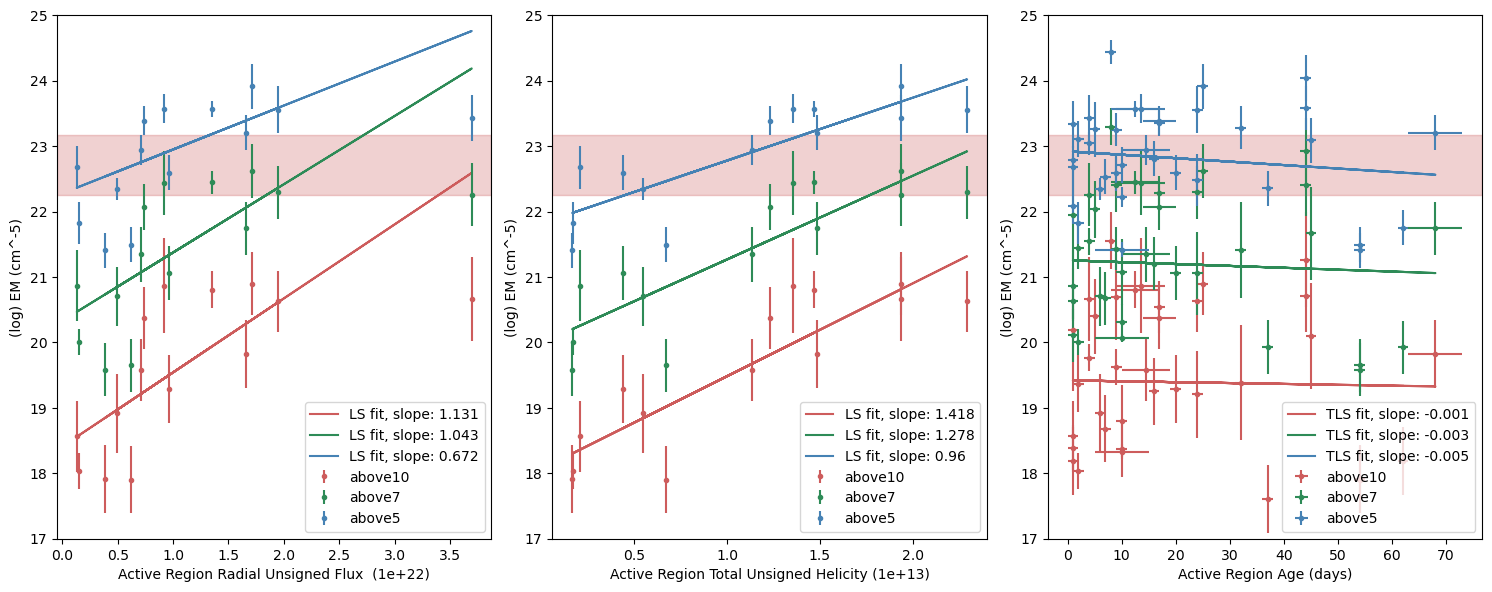

In [37]:
# """
# Now we are going to make a TOTAL EM ABOVE CERTAIN THRESHOLDS plot that shows the relationships to age, 
# unsigned flux, and unsigned helicity. 

# """

# fig, axes = plt.subplots(1,3, figsize=(15, 6), tight_layout = {'pad': 1})


# from scipy import odr

# #ODR documentation: https://docs.scipy.org/doc/scipy-1.16.0/reference/odr.html

# def f(B, x):
#     #Linear function
#     return B[0]*x + B[1]
    
# linear = odr.Model(f)

# params = ['above10', 'above7', 'above5']
# tcolors = ['indianred', 'seagreen', 'steelblue']
# skh = [False, False, False]

# ages, hparr, hparl, heli, regions = haa.fetch_age_and_usflux(all_targets, lonthresh=60, plot=False, check_quiet=True)


# for i in range(0, len(params)):

#     dataparam, ages, stdvs, sks = haa.get_ages_vs_params(all_targets, param=params[i], return_stdvs=True,
#                                                     skiphuh=skh[i])

#     #Get indices of regions that are within the longitude threshold (to plot DEM params vs HARP params)
#     trs = np.where(np.array([1 if s in regions else 0 for s in sks]) == 1)[0]
#     yerr_ = stdvs[trs]
#     wwy = [1/y for y in yerr_]

#     #Plot vs. radial unsigned flux.
#     ax=axes[0]
#     norm=1e22

#     herr = hparr[:,1]/norm #/1e22
#     wwx = [1/y for y in herr]

#     #[print(s) if (s not in sks) else print('') for s in regions]

#     ax.errorbar(hparr[:,0]/norm, dataparam[trs,0], color=tcolors[i], yerr=yerr_, #xerr=herr, 
#                 linestyle='none', marker='o', markersize=3, label=params[i])

#     #Fit option with NO weights
#     # m, b = np.polyfit(hparr[:,0]/norm, dataparam[trs,0], 1)
#     # fity = np.array(hparr[:,0]/norm)*m + b
#     # ax.plot(hparr[:,0]/norm, fity, linestyle='dotted', label='unweighted linear fit, slope: '+str(round(m,3)), color='black')

#     #Fit option with y weights only
#     m, b = np.polyfit(hparr[:,0]/norm, dataparam[trs,0], 1, w=wwy)
#     fity = np.array(hparr[:,0]/norm)*m + b
#     ax.plot(hparr[:,0]/norm, fity, label='LS fit, slope: '+str(round(m,3)), color=tcolors[i])    

#     #Fit option which uses x, y weights 
#     # mydata = odr.Data(hparr[:,0]/norm, dataparam[trs,0], wd=wwx, we=wwy)
#     # myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
#     # myoutput = myodr.run()
#     # m, b = myoutput.beta
#     # fity = np.array(hparr[:,0]/norm)*m + b
#     # ax.plot(hparr[:,0]/norm, fity, linestyle='dotted', label='TLS linear fit, slope: '+str(round(m,3)), color=tcolors[i])

#     ax.axhspan(np.log10(1.8e22), np.log10(1.5e23), color='indianred', alpha=0.1)

#     #ax.set_title(titles[+i])
#     ax.legend(loc='lower right')
#     ax.set_xlabel('Active Region Radial Unsigned Flux  ('+"{:.0e}".format(norm)+')')
#     ax.set_ylabel('(log) EM (cm^-5)')
#     ax.set_ylim([17,25])
    

#     #Plot vs. unsigned helicity.
#     ax=axes[1]
#     norm=1e13

#     herr = heli[:,1]/norm
#     wwx = [1/y for y in herr]

#     ax.errorbar(heli[:,0]/norm, dataparam[trs,0], color=tcolors[i], yerr=yerr_, #xerr=herr, 
#                 linestyle='none', marker='o', markersize=3, label=params[i])

#     #Fit option with y weights only
#     m, b = np.polyfit(heli[:,0]/norm, dataparam[trs,0], 1)
#     fity = np.array(heli[:,0]/norm)*m + b
#     ax.plot(heli[:,0]/norm, fity, label='LS fit, slope: '+str(round(m,3)), color=tcolors[i])

#     #Fit option with NO weights
#     # m, b = np.polyfit(heli[:,0]/norm, dataparam[trs,0], 1, w=wwy)
#     # fity = np.array(heli[:,0]/norm)*m + b
#     # ax.plot(heli[:,0]/norm, fity, linestyle='dotted', label='unweighted linear fit, slope: '+str(round(m,3)), color='black')

#     #Fit option which uses x, y weights 
#     # mydata = odr.Data(heli[:,0]/norm, dataparam[trs,0], wd=wwx, we=wwy)
#     # myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
#     # myoutput = myodr.run()
#     # m, b = myoutput.beta
#     # fity = np.array(heli[:,0]/norm)*m + b
#     # ax.plot(heli[:,0]/norm, fity, linestyle='dotted', label='TLS linear fit, slope: '+str(round(m,3)), color=tcolors[i])

#     ax.axhspan(np.log10(1.8e22), np.log10(1.5e23), color='indianred', alpha=0.1)

#     #ax.set_title(titles[+i])
#     ax.legend() #loc='lower right') 
#     ax.set_xlabel('Active Region Total Unsigned Helicity ('+"{:.0e}".format(norm)+')')
#     ax.set_ylabel('(log) EM (cm^-5)')
#     ax.set_ylim([17,25])
    

#     ax=axes[2]
    
#     yerr_ = stdvs
#     ageerr = ages[:,0]-ages[:,1]
#     wwy = [1/y for y in yerr_]
#     wwx = [1/y for y in ageerr]

#     ax.errorbar(ages[:,0], dataparam[:,0], color=tcolors[i], yerr=yerr_, xerr=ageerr, 
#                 linestyle='none', marker='o', markersize=3, label=params[i])

#     #Fit option with NO weights
#     # m, b = np.polyfit(ages[:,0], dataparam[:,0], 1)
#     # fity = np.array(ages[:,0])*m + b
#     # ax.plot(ages[:,0], fity, linestyle='dotted', label='unweighted linear fit, slope: '+str(round(m,3)), color='black')

#     mydata = odr.Data(ages[:,0], dataparam[:,0], wd=wwx, we=wwy)
#     myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
#     myoutput = myodr.run()
#     m, b = myoutput.beta
#     fity = np.array(ages[:,0])*m + b
#     ax.plot(ages[:,0], fity, label='TLS fit, slope: '+str(round(m,3)), color=tcolors[i])
#     ax.axhspan(np.log10(1.8e22), np.log10(1.5e23), color='indianred', alpha=0.1)


#     #----------------------------------------------------------------------
#     #OPTION: plot only the HARP regions even for the age plot where others are available.
    
#     # yerr_ = stdvs[trs]
#     # ageerr = ages[trs,0]-ages[trs,1]    

#     # #
#     # wwy = [1/y for y in yerr_]
#     # wwx = [1/y for y in ageerr]


#     # ax.errorbar(ages[trs,0], dataparam[trs,0], color=tcolors[i], yerr=yerr_, xerr=ageerr, 
#     #         linestyle='none', marker='o', markersize=3, label=params[i])
    
#     # mydata = odr.Data(ages[trs,0], dataparam[trs,0], wd=wwx, we=wwy)
#     # myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
#     # myoutput = myodr.run()
#     # m, b = myoutput.beta
#     # fity = np.array(ages[trs,0])*m + b
#     # ax.plot(ages[trs,0], fity, label='TLS fit, slope: '+str(round(m,3)), color=tcolors[i])
#     # ax.axhspan(np.log10(1.8e22), np.log10(1.5e23), color='indianred', alpha=0.1)

#     #----------------------------------------------------------------------

    
#     #ax.set_title(titles[6+i])
#     ax.legend(loc='lower right') 
#     ax.set_xlabel('Active Region Age (days)')
#     ax.set_ylabel('(log) EM (cm^-5)')
#     ax.set_ylim([17,25])


# plt.savefig('EM_vs_external_all.png')   

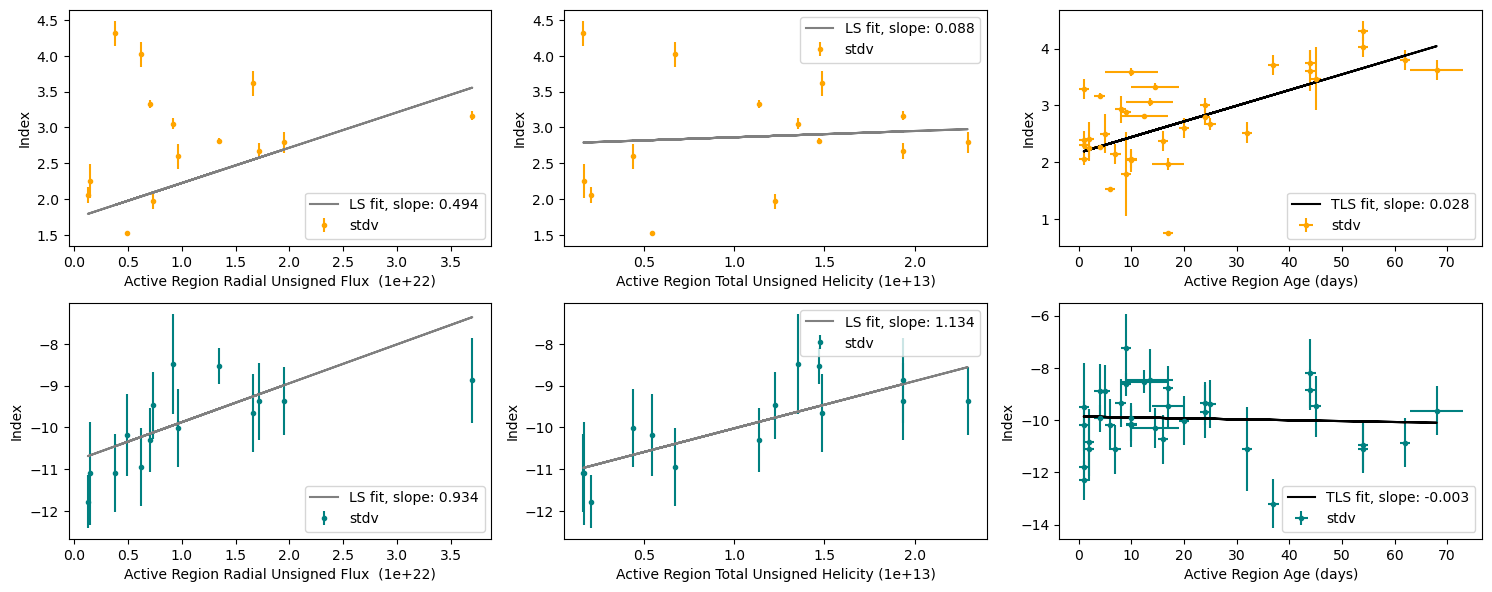

In [39]:
# """
# Now we are going to make a nice power law plot that includes, for both powerlaws, the relationships to age, 
# unsigned flux, and unsigned helicity. 

# """

# fig, axes = plt.subplots(2,3, figsize=(15, 6), tight_layout = {'pad': 1})


# from scipy import odr

# #ODR documentation: https://docs.scipy.org/doc/scipy-1.16.0/reference/odr.html

# def f(B, x):
#     #Linear function
#     return B[0]*x + B[1]
    
# linear = odr.Model(f)

# params = ['lowerpower2', 'upperpower2']
# tcolors = ['orange', 'teal']
# skh = [False, False]

# ages, hparr, hparl, heli, mheli, malp, regions = haa.fetch_age_and_usflux(all_targets, lonthresh=60, plot=False, check_quiet=True)


# for i in range(0, len(params)):

#     dataparam, ages, stdvs, sks = haa.get_ages_vs_params(all_targets, param=params[i], return_stdvs=True,
#                                                     skiphuh=skh[i])

#     #Get indices of regions that are within the longitude threshold (to plot DEM params vs HARP params)
#     trs = np.where(np.array([1 if s in regions else 0 for s in sks]) == 1)[0]
#     yerr_ = stdvs[trs]
#     wwy = [1/y for y in yerr_]

#     #Plot vs. radial unsigned flux.
#     ax=axes[i,0]
#     norm=1e22

#     herr = hparr[:,1]/norm #/1e22
#     wwx = [1/y for y in herr]

#     #[print(s) if (s not in sks) else print('') for s in regions]

#     ax.errorbar(hparr[:,0]/norm, dataparam[trs,0], color=tcolors[i], yerr=yerr_, #xerr=herr, 
#                 linestyle='none', marker='o', markersize=3, label='stdv')

#     #Fit option with NO weights
#     # m, b = np.polyfit(hparr[:,0]/norm, dataparam[trs,0], 1)
#     # fity = np.array(hparr[:,0]/norm)*m + b
#     # ax.plot(hparr[:,0]/norm, fity, linestyle='dotted', label='unweighted linear fit, slope: '+str(round(m,3)), color='black')

#     #Fit option with y weights only
#     m, b = np.polyfit(hparr[:,0]/norm, dataparam[trs,0], 1, w=wwy)
#     fity = np.array(hparr[:,0]/norm)*m + b
#     ax.plot(hparr[:,0]/norm, fity, label='LS fit, slope: '+str(round(m,3)), color='grey')    

#     #Fit option which uses x, y weights 
#     # mydata = odr.Data(hparr[:,0]/norm, dataparam[trs,0], wd=wwx, we=wwy)
#     # myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
#     # myoutput = myodr.run()
#     # m, b = myoutput.beta
#     # fity = np.array(hparr[:,0]/norm)*m + b
#     # ax.plot(hparr[:,0]/norm, fity, linestyle='dotted', label='TLS linear fit, slope: '+str(round(m,3)), color=tcolors[i])

#     #ax.set_title(titles[+i])
#     ax.legend(loc='lower right')
#     ax.set_xlabel('Active Region Radial Unsigned Flux  ('+"{:.0e}".format(norm)+')')
#     ax.set_ylabel('Index')
    

#     #Plot vs. unsigned helicity.
#     ax=axes[i, 1]
#     norm=1e13

#     herr = heli[:,1]/norm
#     wwx = [1/y for y in herr]

#     ax.errorbar(heli[:,0]/norm, dataparam[trs,0], color=tcolors[i], yerr=yerr_, #xerr=herr, 
#                 linestyle='none', marker='o', markersize=3, label='stdv')

#     #Fit option with y weights only
#     m, b = np.polyfit(heli[:,0]/norm, dataparam[trs,0], 1)
#     fity = np.array(heli[:,0]/norm)*m + b
#     ax.plot(heli[:,0]/norm, fity, label='LS fit, slope: '+str(round(m,3)), color='grey')

#     #Fit option with NO weights
#     # m, b = np.polyfit(heli[:,0]/norm, dataparam[trs,0], 1, w=wwy)
#     # fity = np.array(heli[:,0]/norm)*m + b
#     # ax.plot(heli[:,0]/norm, fity, linestyle='dotted', label='unweighted linear fit, slope: '+str(round(m,3)), color='black')

#     #Fit option which uses x, y weights 
#     # mydata = odr.Data(heli[:,0]/norm, dataparam[trs,0], wd=wwx, we=wwy)
#     # myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
#     # myoutput = myodr.run()
#     # m, b = myoutput.beta
#     # fity = np.array(heli[:,0]/norm)*m + b
#     # ax.plot(heli[:,0]/norm, fity, linestyle='dotted', label='TLS linear fit, slope: '+str(round(m,3)), color=tcolors[i])

#     #ax.set_title(titles[+i])
#     ax.legend() #loc='lower right') 
#     ax.set_xlabel('Active Region Total Unsigned Helicity ('+"{:.0e}".format(norm)+')')
#     ax.set_ylabel('Index')

    

#     ax=axes[i, 2]
    
#     yerr_ = stdvs
#     ageerr = ages[:,0]-ages[:,1]

    

#     #
#     wwy = [1/y for y in yerr_]
#     wwx = [1/y for y in ageerr]

#     ax.errorbar(ages[:,0], dataparam[:,0], color=tcolors[i], yerr=yerr_, xerr=ageerr, 
#                 linestyle='none', marker='o', markersize=3, label='stdv')

#     #Fit option with NO weights
#     # m, b = np.polyfit(ages[:,0], dataparam[:,0], 1)
#     # fity = np.array(ages[:,0])*m + b
#     # ax.plot(ages[:,0], fity, linestyle='dotted', label='unweighted linear fit, slope: '+str(round(m,3)), color='black')

#     mydata = odr.Data(ages[:,0], dataparam[:,0], wd=wwx, we=wwy)
#     myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
#     myoutput = myodr.run()
#     m, b = myoutput.beta
#     fity = np.array(ages[:,0])*m + b
#     ax.plot(ages[:,0], fity, label='TLS fit, slope: '+str(round(m,3)), color='black')

#     #ax.set_title(titles[6+i])
#     ax.legend(loc='lower right') 
#     ax.set_xlabel('Active Region Age (days)')
#     ax.set_ylabel('Index')

# plt.savefig('powerlaws_vs_external.png')

/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jmdunca2/do-dem//dodem/HARP_and_age.py:667: RuntimeWarning: invalid value

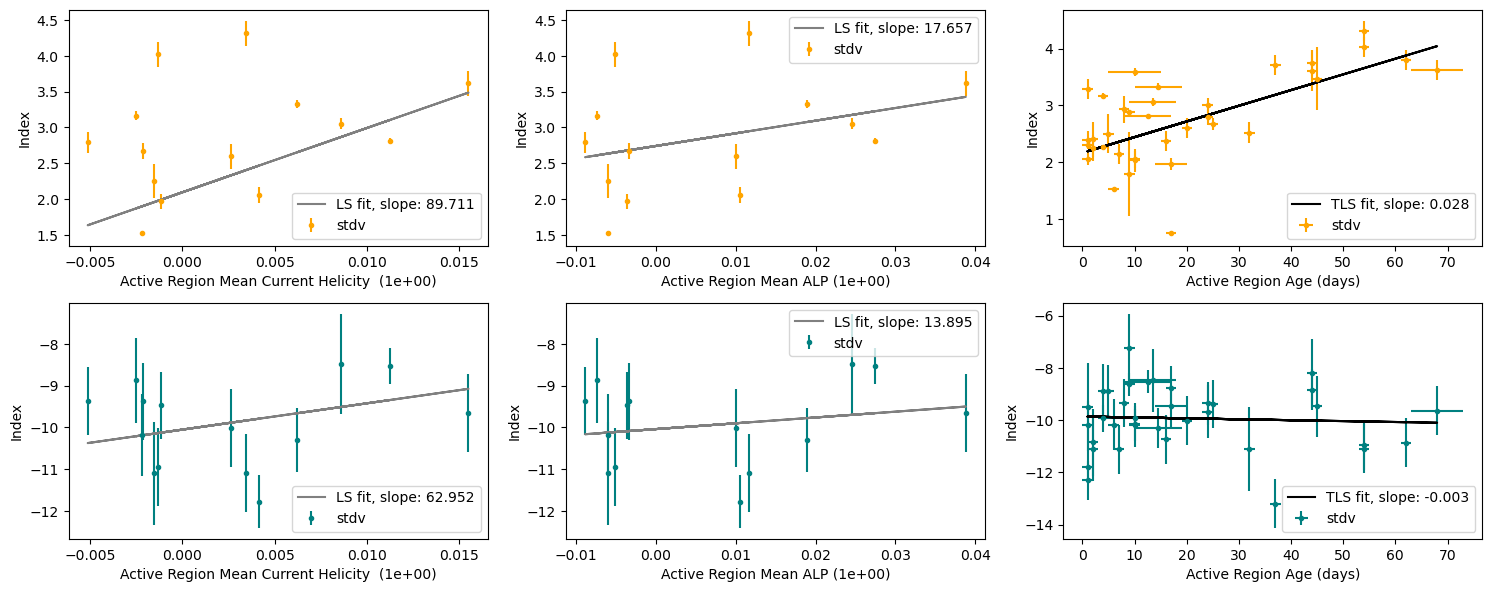

In [3]:
# """
# Now we are going to make a nice power law plot that includes, for both powerlaws, the relationships to age, 
# unsigned flux, and unsigned helicity. 

# """

# fig, axes = plt.subplots(2,3, figsize=(15, 6), tight_layout = {'pad': 1})


# from scipy import odr

# #ODR documentation: https://docs.scipy.org/doc/scipy-1.16.0/reference/odr.html

# def f(B, x):
#     #Linear function
#     return B[0]*x + B[1]
    
# linear = odr.Model(f)

# params = ['lowerpower2', 'upperpower2']
# tcolors = ['orange', 'teal']
# skh = [False, False]

# ages, hparr, hparl, heli, mheli, malp, regions = haa.fetch_age_and_usflux(all_targets, lonthresh=60, plot=False, check_quiet=True)


# for i in range(0, len(params)):

#     dataparam, ages, stdvs, sks = haa.get_ages_vs_params(all_targets, param=params[i], return_stdvs=True,
#                                                     skiphuh=skh[i])

#     #Get indices of regions that are within the longitude threshold (to plot DEM params vs HARP params)
#     trs = np.where(np.array([1 if s in regions else 0 for s in sks]) == 1)[0]
#     yerr_ = stdvs[trs]
#     wwy = [1/y for y in yerr_]

#     #Plot vs. radial unsigned flux.
#     ax=axes[i,0]
#     norm=1 #e22
#     magpar=mheli

#     herr = magpar[:,1]/norm #/1e22
#     wwx = [1/y for y in herr]

#     #[print(s) if (s not in sks) else print('') for s in regions]

#     ax.errorbar(magpar[:,0]/norm, dataparam[trs,0], color=tcolors[i], yerr=yerr_, #xerr=herr, 
#                 linestyle='none', marker='o', markersize=3, label='stdv')

#     #Fit option with NO weights
#     # m, b = np.polyfit(hparr[:,0]/norm, dataparam[trs,0], 1)
#     # fity = np.array(hparr[:,0]/norm)*m + b
#     # ax.plot(hparr[:,0]/norm, fity, linestyle='dotted', label='unweighted linear fit, slope: '+str(round(m,3)), color='black')

#     #Fit option with y weights only
#     m, b = np.polyfit(magpar[:,0]/norm, dataparam[trs,0], 1, w=wwy)
#     fity = np.array(magpar[:,0]/norm)*m + b
#     ax.plot(magpar[:,0]/norm, fity, label='LS fit, slope: '+str(round(m,3)), color='grey')    

#     #Fit option which uses x, y weights 
#     # mydata = odr.Data(hparr[:,0]/norm, dataparam[trs,0], wd=wwx, we=wwy)
#     # myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
#     # myoutput = myodr.run()
#     # m, b = myoutput.beta
#     # fity = np.array(hparr[:,0]/norm)*m + b
#     # ax.plot(hparr[:,0]/norm, fity, linestyle='dotted', label='TLS linear fit, slope: '+str(round(m,3)), color=tcolors[i])

#     #ax.set_title(titles[+i])
#     ax.legend(loc='lower right')
#     ax.set_xlabel('Active Region Mean Current Helicity  ('+"{:.0e}".format(norm)+')')
#     ax.set_ylabel('Index')
    

#     #Plot vs. unsigned helicity.
#     ax=axes[i, 1]
#     norm=1 #e13
#     magpar=malp

#     herr = magpar[:,1]/norm
#     wwx = [1/y for y in herr]

#     ax.errorbar(magpar[:,0]/norm, dataparam[trs,0], color=tcolors[i], yerr=yerr_, #xerr=herr, 
#                 linestyle='none', marker='o', markersize=3, label='stdv')

#     #Fit option with y weights only
#     m, b = np.polyfit(magpar[:,0]/norm, dataparam[trs,0], 1)
#     fity = np.array(magpar[:,0]/norm)*m + b
#     ax.plot(magpar[:,0]/norm, fity, label='LS fit, slope: '+str(round(m,3)), color='grey')

#     #Fit option with NO weights
#     # m, b = np.polyfit(heli[:,0]/norm, dataparam[trs,0], 1, w=wwy)
#     # fity = np.array(heli[:,0]/norm)*m + b
#     # ax.plot(heli[:,0]/norm, fity, linestyle='dotted', label='unweighted linear fit, slope: '+str(round(m,3)), color='black')

#     #Fit option which uses x, y weights 
#     # mydata = odr.Data(heli[:,0]/norm, dataparam[trs,0], wd=wwx, we=wwy)
#     # myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
#     # myoutput = myodr.run()
#     # m, b = myoutput.beta
#     # fity = np.array(heli[:,0]/norm)*m + b
#     # ax.plot(heli[:,0]/norm, fity, linestyle='dotted', label='TLS linear fit, slope: '+str(round(m,3)), color=tcolors[i])

#     #ax.set_title(titles[+i])
#     ax.legend() #loc='lower right') 
#     ax.set_xlabel('Active Region Mean ALP ('+"{:.0e}".format(norm)+')')
#     ax.set_ylabel('Index')

    

#     ax=axes[i, 2]
    
#     yerr_ = stdvs
#     ageerr = ages[:,0]-ages[:,1]

    

#     #
#     wwy = [1/y for y in yerr_]
#     wwx = [1/y for y in ageerr]

#     ax.errorbar(ages[:,0], dataparam[:,0], color=tcolors[i], yerr=yerr_, xerr=ageerr, 
#                 linestyle='none', marker='o', markersize=3, label='stdv')

#     #Fit option with NO weights
#     # m, b = np.polyfit(ages[:,0], dataparam[:,0], 1)
#     # fity = np.array(ages[:,0])*m + b
#     # ax.plot(ages[:,0], fity, linestyle='dotted', label='unweighted linear fit, slope: '+str(round(m,3)), color='black')

#     mydata = odr.Data(ages[:,0], dataparam[:,0], wd=wwx, we=wwy)
#     myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
#     myoutput = myodr.run()
#     m, b = myoutput.beta
#     fity = np.array(ages[:,0])*m + b
#     ax.plot(ages[:,0], fity, label='TLS fit, slope: '+str(round(m,3)), color='black')

#     #ax.set_title(titles[6+i])
#     ax.legend(loc='lower right') 
#     ax.set_xlabel('Active Region Age (days)')
#     ax.set_ylabel('Index')

# plt.savefig('powerlaws_vs_external_mheli_malp.png')

3.031279019024324e+20
3.2989374904916192e-21
[0.         0.02588114 0.00263232 0.00495086 0.03332863 0.04868288
 0.03807732 0.02436993 0.02197013 0.00655893 0.00491791 0.14907604
 0.00937371 0.02424649]
[         inf  38.63817673 379.89292354 201.98509669  30.00423727
  20.54110334  26.26235174  41.03418454  45.51633648 152.46383267
 203.33847304   6.70798621 106.68138709  41.24308924]


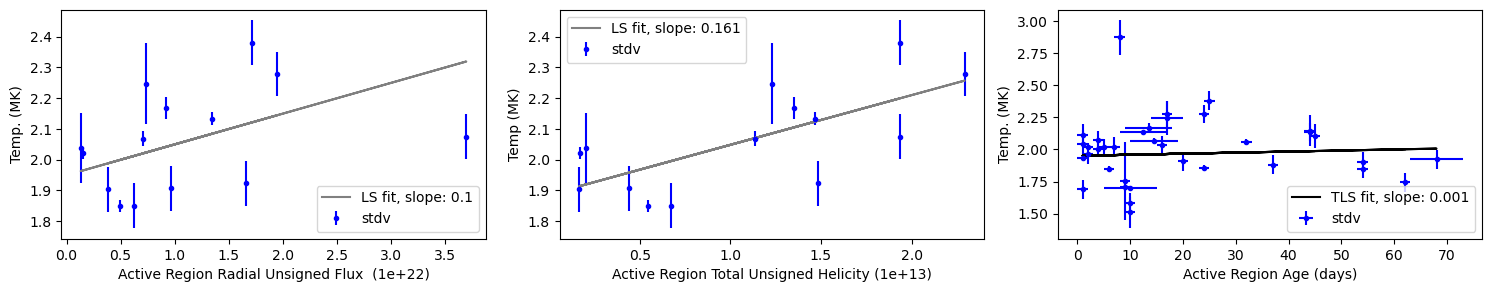

In [5]:
# """
# Now we are going to make a nice power law plot that includes, for both powerlaws, the relationships to age, 
# unsigned flux, and unsigned helicity. 

# """

# fig, axes = plt.subplots(1,3, figsize=(15, 3), tight_layout = {'pad': 1})


# from scipy import odr

# #ODR documentation: https://docs.scipy.org/doc/scipy-1.16.0/reference/odr.html

# def f(B, x):
#     #Linear function
#     return B[0]*x + B[1]
    
# linear = odr.Model(f)

# params = ['peak']
# tcolors = ['blue']
# skh = [False]

# ages, hparr, hparl, heli, mheli, malp, regions = haa.fetch_age_and_usflux(all_targets, lonthresh=60, plot=False, check_quiet=True)


# for i in range(0, len(params)):

#     dataparam, ages, stdvs, sks = haa.get_ages_vs_params(all_targets, param=params[i], return_stdvs=True,
#                                                     skiphuh=skh[i])

#     #Get indices of regions that are within the longitude threshold (to plot DEM params vs HARP params)
#     trs = np.where(np.array([1 if s in regions else 0 for s in sks]) == 1)[0]
#     yerr_ = stdvs[trs]
#     wwy = [1/y for y in yerr_]

#     #Plot vs. radial unsigned flux.
#     ax=axes[0]
#     norm=1e22

#     herr = hparr[:,1]/norm #/1e22
#     wwx = [1/y for y in herr]

#     #[print(s) if (s not in sks) else print('') for s in regions]

#     ax.errorbar(hparr[:,0]/norm, dataparam[trs,0], color=tcolors[i], yerr=yerr_, #xerr=herr, 
#                 linestyle='none', marker='o', markersize=3, label='stdv')

#     #Fit option with NO weights
#     # m, b = np.polyfit(hparr[:,0]/norm, dataparam[trs,0], 1)
#     # fity = np.array(hparr[:,0]/norm)*m + b
#     # ax.plot(hparr[:,0]/norm, fity, linestyle='dotted', label='unweighted linear fit, slope: '+str(round(m,3)), color='black')

#     #Fit option with y weights only
#     m, b = np.polyfit(hparr[:,0]/norm, dataparam[trs,0], 1, w=wwy)
#     fity = np.array(hparr[:,0]/norm)*m + b
#     ax.plot(hparr[:,0]/norm, fity, label='LS fit, slope: '+str(round(m,3)), color='grey')    

#     #Fit option which uses x, y weights 
#     # mydata = odr.Data(hparr[:,0]/norm, dataparam[trs,0], wd=wwx, we=wwy)
#     # myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
#     # myoutput = myodr.run()
#     # m, b = myoutput.beta
#     # fity = np.array(hparr[:,0]/norm)*m + b
#     # ax.plot(hparr[:,0]/norm, fity, linestyle='dotted', label='TLS linear fit, slope: '+str(round(m,3)), color=tcolors[i])

#     #ax.set_title(titles[+i])
#     ax.legend(loc='lower right')
#     ax.set_xlabel('Active Region Radial Unsigned Flux  ('+"{:.0e}".format(norm)+')')
#     ax.set_ylabel('Temp. (MK)')
    

#     #Plot vs. unsigned helicity.
#     ax=axes[1]
#     norm=1e13

#     herr = heli[:,1]/norm
#     wwx = [1/y for y in herr]

#     ax.errorbar(heli[:,0]/norm, dataparam[trs,0], color=tcolors[i], yerr=yerr_, #xerr=herr, 
#                 linestyle='none', marker='o', markersize=3, label='stdv')

#     #Fit option with y weights only
#     m, b = np.polyfit(heli[:,0]/norm, dataparam[trs,0], 1)
#     fity = np.array(heli[:,0]/norm)*m + b
#     ax.plot(heli[:,0]/norm, fity, label='LS fit, slope: '+str(round(m,3)), color='grey')

#     #Fit option with NO weights
#     # m, b = np.polyfit(heli[:,0]/norm, dataparam[trs,0], 1, w=wwy)
#     # fity = np.array(heli[:,0]/norm)*m + b
#     # ax.plot(heli[:,0]/norm, fity, linestyle='dotted', label='unweighted linear fit, slope: '+str(round(m,3)), color='black')

#     #Fit option which uses x, y weights 
#     # mydata = odr.Data(heli[:,0]/norm, dataparam[trs,0], wd=wwx, we=wwy)
#     # myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
#     # myoutput = myodr.run()
#     # m, b = myoutput.beta
#     # fity = np.array(heli[:,0]/norm)*m + b
#     # ax.plot(heli[:,0]/norm, fity, linestyle='dotted', label='TLS linear fit, slope: '+str(round(m,3)), color=tcolors[i])

#     #ax.set_title(titles[+i])
#     ax.legend() #loc='lower right') 
#     ax.set_xlabel('Active Region Total Unsigned Helicity ('+"{:.0e}".format(norm)+')')
#     ax.set_ylabel('Temp (MK)')

    

#     ax=axes[2]
    
#     yerr_ = stdvs
#     ageerr = ages[:,0]-ages[:,1]    

#     #
#     wwy = [1/y for y in yerr_]
#     wwx = [1/y for y in ageerr]

#     ax.errorbar(ages[:,0], dataparam[:,0], color=tcolors[i], yerr=yerr_, xerr=ageerr, 
#                 linestyle='none', marker='o', markersize=3, label='stdv')

#     #Fit option with NO weights
#     # m, b = np.polyfit(ages[:,0], dataparam[:,0], 1)
#     # fity = np.array(ages[:,0])*m + b
#     # ax.plot(ages[:,0], fity, linestyle='dotted', label='unweighted linear fit, slope: '+str(round(m,3)), color='black')

#     mydata = odr.Data(ages[:,0], dataparam[:,0], wd=wwx, we=wwy)
#     myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
#     myoutput = myodr.run()
#     m, b = myoutput.beta
#     fity = np.array(ages[:,0])*m + b
#     ax.plot(ages[:,0], fity, label='TLS fit, slope: '+str(round(m,3)), color='black')

#     #ax.set_title(titles[6+i])
#     ax.legend(loc='lower right') 
#     ax.set_xlabel('Active Region Age (days)')
#     ax.set_ylabel('Temp. (MK)')

# plt.savefig('peaks_vs_external.png')

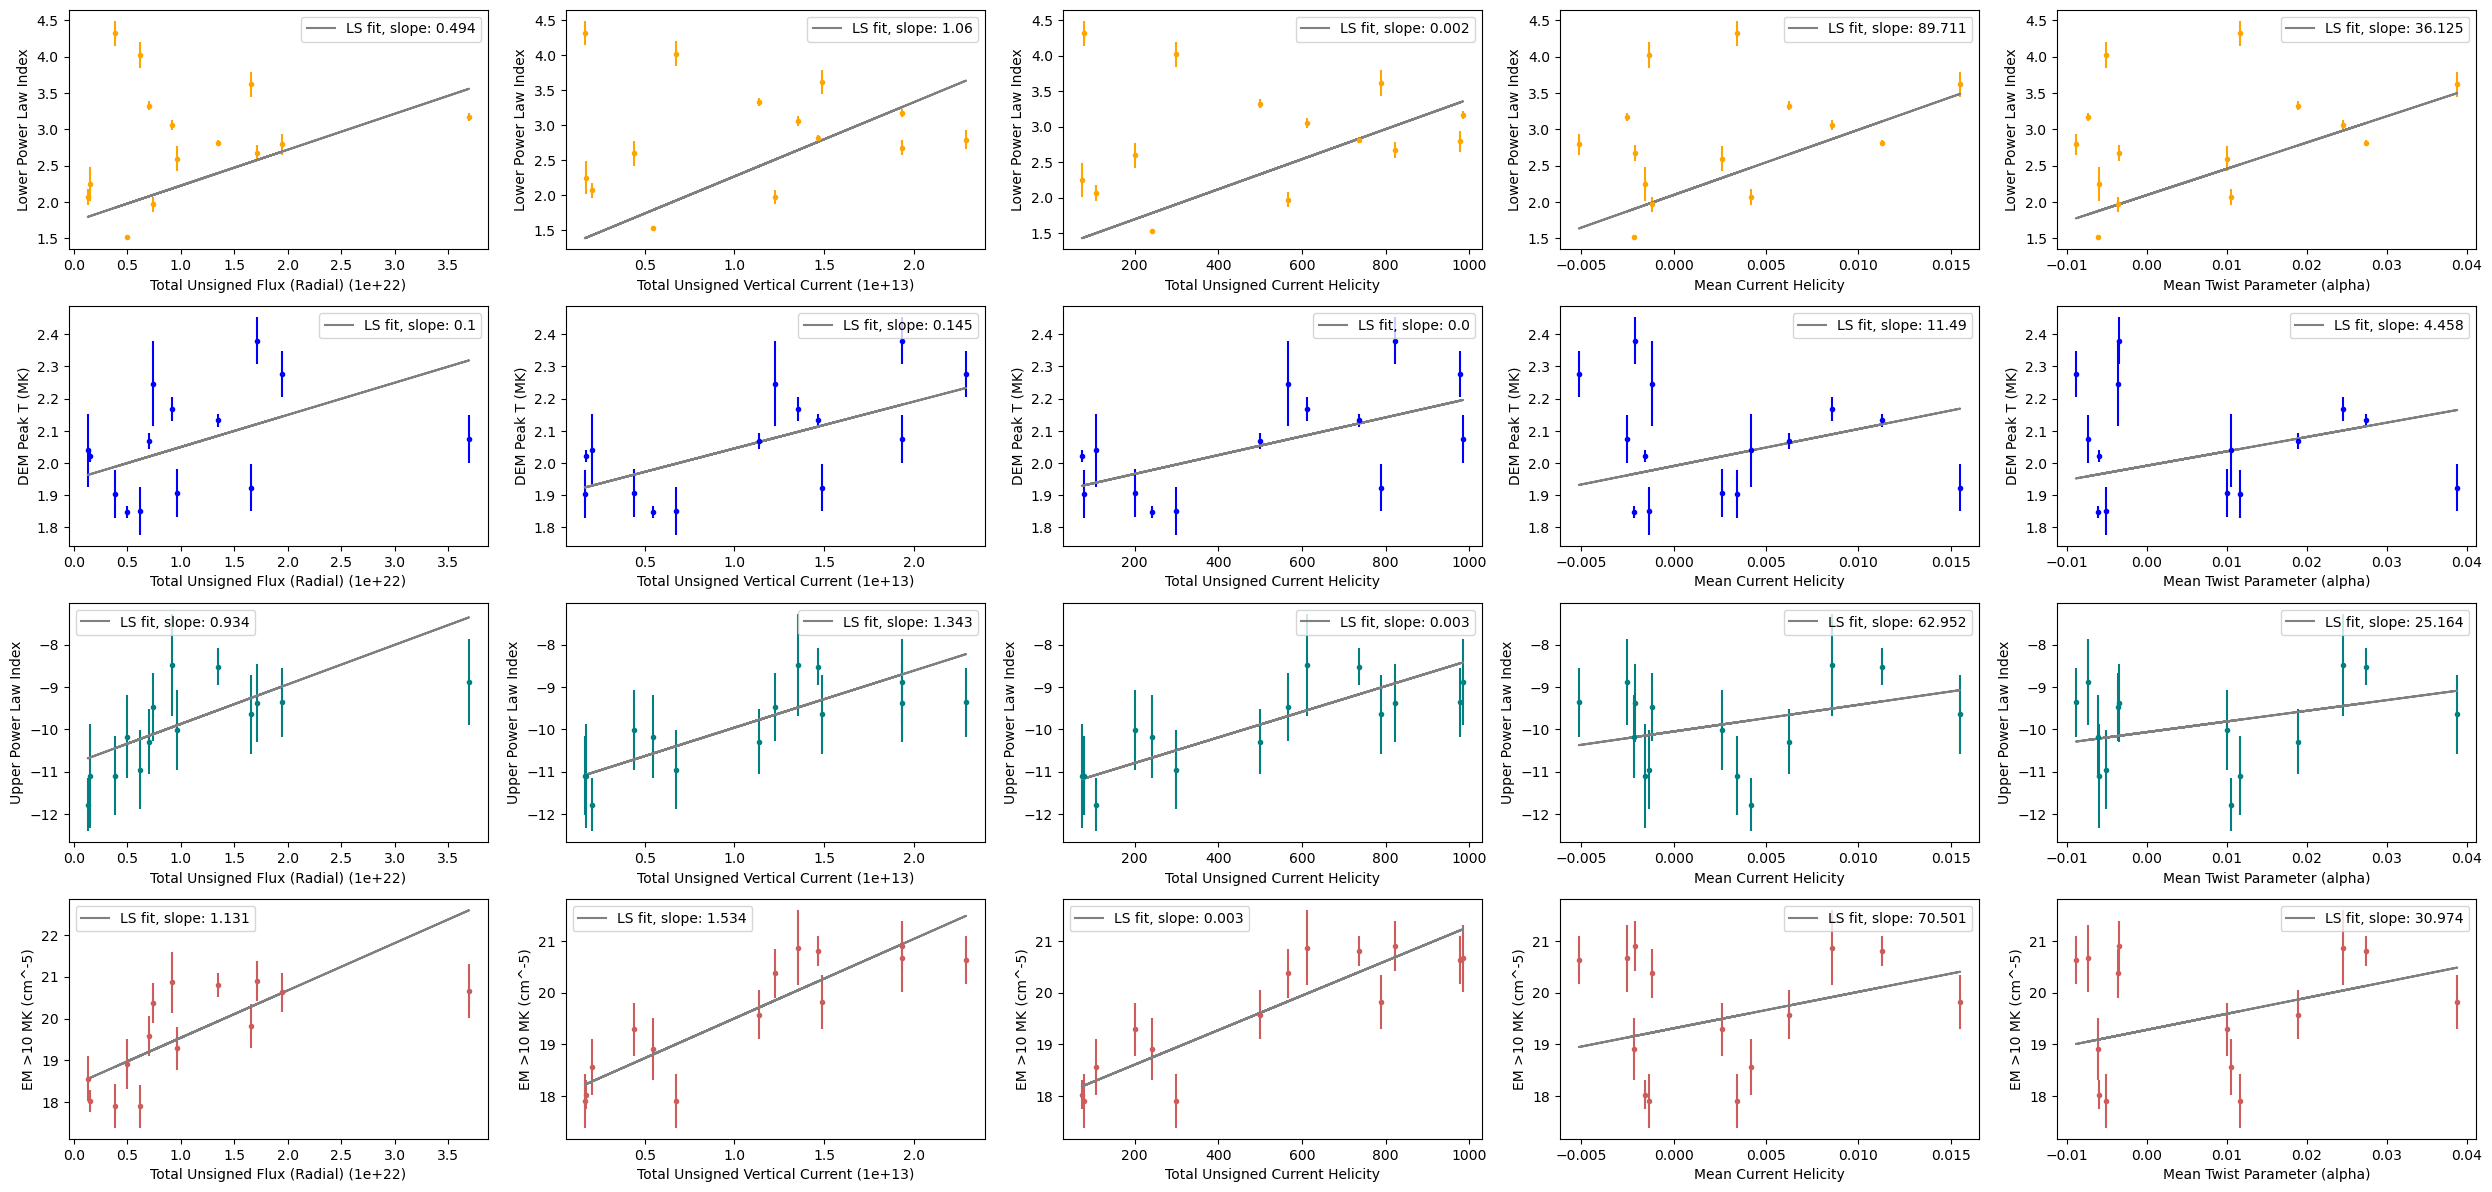

In [37]:
#MEGAPLOT
importlib.reload(haa)

params = ['lowerpower2', 'peak', 'upperpower2', 'above10']
paramlabels = ['Lower Power Law Index', 'DEM Peak T (MK)', 'Upper Power Law Index', 'EM >10 MK (cm^-5)']
tcolors = ['orange', 'blue', 'teal', 'indianred']
skh = [False, False, False, False]

mparams = ['usflx', 'tuvc', 'tuheli', 'mheli', 'malp']

magparams = haa.fetch_age_and_usflux(all_targets, lonthresh=60, plot=False, check_quiet=True)

regions = magparams['regions']['vals']

fig, axes = plt.subplots(len(params),len(mparams), figsize=(5*len(mparams), 3*len(params)), tight_layout = {'pad': 1})

for i in range(0, len(params)):
    for j in range(0, len(mparams)):

        dataparam, ages, stdvs, sks = haa.get_ages_vs_params(all_targets, param=params[i], return_stdvs=True,
                                                    skiphuh=skh[i])

        #Get indices of regions that are within the longitude threshold (to plot DEM params vs HARP params)
        trs = np.where(np.array([1 if s in regions else 0 for s in sks]) == 1)[0]
        yerr_ = stdvs[trs]
        wwy = [1/y for y in yerr_]
        

        #Plot vs. radial unsigned flux.
        ax=axes[i,j]
        magpar=magparams[mparams[j]]['vals']
        norm=magparams[mparams[j]]['norm']

        herr = magpar[:,1]/norm 
        wwx = [1/y for y in herr]
    
        #[print(s) if (s not in sks) else print('') for s in regions]
    
        ax.errorbar(magpar[:,0]/norm, dataparam[trs,0], color=tcolors[i], yerr=yerr_, #xerr=herr, 
                    linestyle='none', marker='o', markersize=3)

        #Fit option with y weights only
        m, b = np.polyfit(magpar[:,0]/norm, dataparam[trs,0], 1, w=wwy)
        fity = np.array(magpar[:,0]/norm)*m + b
        ax.plot(magpar[:,0]/norm, fity, label='LS fit, slope: '+str(round(m,3)), color='grey')  


        
        if norm != 1:
            ax.set_xlabel(magparams[mparams[j]]['name']+' ('+"{:.0e}".format(norm)+')')
        else:
            ax.set_xlabel(magparams[mparams[j]]['name'])
        ax.set_ylabel(paramlabels[i])
        ax.legend()


plt.savefig('all_mag_params.png')

0.003 0.332 26-jul-16_2 region_0
-0.001 1.995 29-may-18_1 region_0
0.004 0.364 09-sep-18 region_0
-0.002 0.302 10-sep-18 region_0
-0.005 2.865 12-apr-19 region_0
-0.002 2.791 13-apr-19 region_0
-0.002 0.58 29-jan-20 region_0
0.011 1.139 06-jun-20 region_0
0.009 1.214 07-jun-20 region_0
0.006 1.283 08-jun-20 region_0
0.016 1.053 20-jan-21 region_0
-0.003 1.861 29-apr-21 region_0
0.003 0.142 30-jul-21_1 region_0
-0.001 1.125 30-jul-21_1 region_1


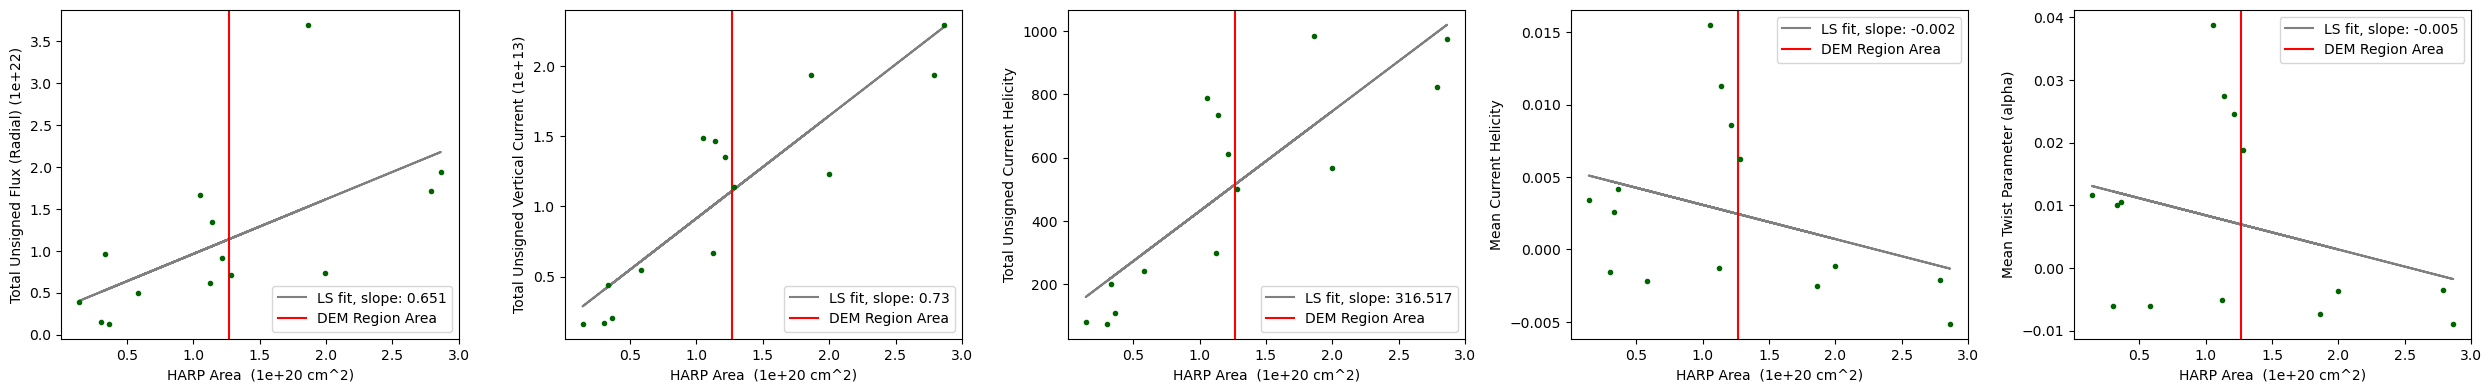

In [126]:
importlib.reload(haa)

mparams = ['usflx', 'tuvc', 'tuheli', 'mheli', 'malp']

fig, axes = plt.subplots(1,len(mparams), figsize=(5*len(mparams), 4), tight_layout = {'pad': 1})

magparams = haa.fetch_age_and_usflux(all_targets, lonthresh=60, plot=False, check_quiet=True)

for j in range(0, len(mparams)):
    ax=axes[j]
    magpar=magparams[mparams[j]]['vals']
    norm=magparams[mparams[j]]['norm']
    areanorm=1e20

    if mparams[j] == 'mheli':
        for m in range(0, len(magpar[:,0])):
            print(round(magpar[:,0][m],3), round(area[m], 3), regions[m])

    herr = magpar[:,1]/norm 
    wwy = [1/y for y in herr]

    area=magparams['areas']['vals'][:,0]/areanorm
    

    ax.errorbar(area, magpar[:,0]/norm, color=tcolors[i], #yerr=yerr_, #xerr=herr, 
                    linestyle='none', marker='o', markersize=3)
    
    #Fit option with y weights only
    m, b = np.polyfit(area, magpar[:,0]/norm, 1) #, w=wwy)
    fity = np.array(area)*m + b
    ax.plot(area, fity, label='LS fit, slope: '+str(round(m,3)), color='grey')  


    
    if norm != 1:
        ax.set_ylabel(magparams[mparams[j]]['name']+' ('+"{:.0e}".format(norm)+')')
    else:
        ax.set_ylabel(magparams[mparams[j]]['name'])

    ax.axvline((((150*u.arcsec*750*(u.km/u.arcsec))**2).to(u.cm**2).value)/areanorm, color='red', label='DEM Region Area')
    ax.set_xlabel('HARP Area '+' ('+"{:.0e}".format(areanorm)+' cm^2)')
    ax.legend()    

plt.savefig('mag_params_vs_harp_area.png')

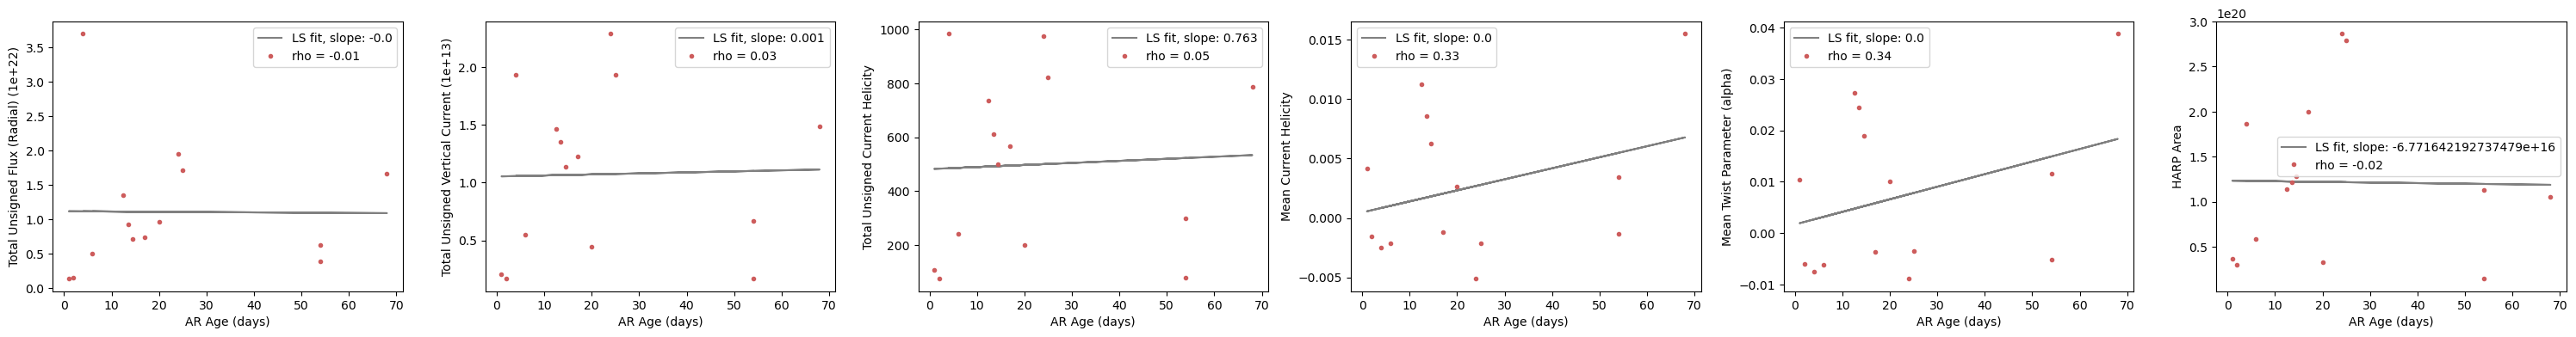

In [117]:
mparams = ['usflx', 'tuvc', 'tuheli', 'mheli', 'malp', 'areas']

fig, axes = plt.subplots(1,len(mparams), figsize=(5*len(mparams), 4), tight_layout = {'pad': 1})

magparams = haa.fetch_age_and_usflux(all_targets, lonthresh=60, plot=False, check_quiet=True)

regions = magparams['regions']['vals']

dataparam, ages, stdvs, sks = haa.get_ages_vs_params(all_targets, param='peak', return_stdvs=True,
                                                    skiphuh=False)

#Get indices of regions that are within the longitude threshold (to plot DEM params vs HARP params)
trs = np.where(np.array([1 if s in regions else 0 for s in sks]) == 1)[0]

ages = ages[trs,0]

for j in range(0, len(mparams)):
    ax=axes[j]
    magpar=magparams[mparams[j]]['vals']
    norm=magparams[mparams[j]]['norm']
    areanorm=1e20

    herr = magpar[:,1]/norm 
    wwy = [1/y for y in herr]

    #area=magparams['areas']['vals'][:,0]/areanorm
    
    
    rho=round(np.corrcoef(ages, magpar[:,0]/norm)[0,1],2)
    ax.errorbar(ages, magpar[:,0]/norm, color=tcolors[i], #yerr=yerr_, #xerr=herr, 
                    linestyle='none', marker='o', markersize=3, label='rho = '+str(rho))
    
    #Fit option with y weights only
    m, b = np.polyfit(ages, magpar[:,0]/norm, 1) #, w=wwy)
    fity = np.array(ages)*m + b
    ax.plot(ages, fity, label='LS fit, slope: '+str(round(m,3)), color='grey')  


    
    if norm != 1:
        ax.set_ylabel(magparams[mparams[j]]['name']+' ('+"{:.0e}".format(norm)+')')
    else:
        ax.set_ylabel(magparams[mparams[j]]['name'])

    #ax.axvline((((150*u.arcsec*750*(u.km/u.arcsec))**2).to(u.cm**2).value)/areanorm, color='red', label='DEM Region Area')
    ax.set_xlabel('AR Age (days)')
    ax.legend()    

plt.savefig('mag_params_vs_AGE.png')

[ 1.   1.   1.   1.   2.   2.   4.   4.   5.   6.   7.   8.   9.   9.
 10.  10.  10.  12.5 13.5 14.5 16.  17.  17.  20.  24.  24.  25.  32.
 37.  44.  44.  45.  54.  54.  62.  68. ]
['03-may-21_1 region_0', '08-jan-21 region_0', '26-jul-16_1 region_1', '09-sep-18 region_0', '02-sep-15 region_0', '10-sep-18 region_0', '01-sep-15 region_0', '29-apr-21 region_0', '02-sep-15 region_1', '29-jan-20 region_0', '29-may-18_2 region_0', '11-sep-17 region_0', '12-sep-17 region_1', '12-sep-17 region_0', '13-sep-17 region_0', '13-sep-17 region_1', '03-may-21_2 region_0', '06-jun-20 region_0', '07-jun-20 region_0', '08-jun-20 region_0', '26-jul-16_1 region_0', '27-jul-16_1 region_0', '29-may-18_1 region_0', '26-jul-16_2 region_0', '12-apr-19 region_0', '22-apr-16_2 region_0', '13-apr-19 region_0', '19-feb-16 region_0', '10-oct-17 region_1', '20-jul-21 region_0', '20-jul-21 region_1', '10-oct-17 region_0', '30-jul-21_1 region_1', '30-jul-21_1 region_0', '30-jul-21_2 region_0', '20-jan-21 region_0']


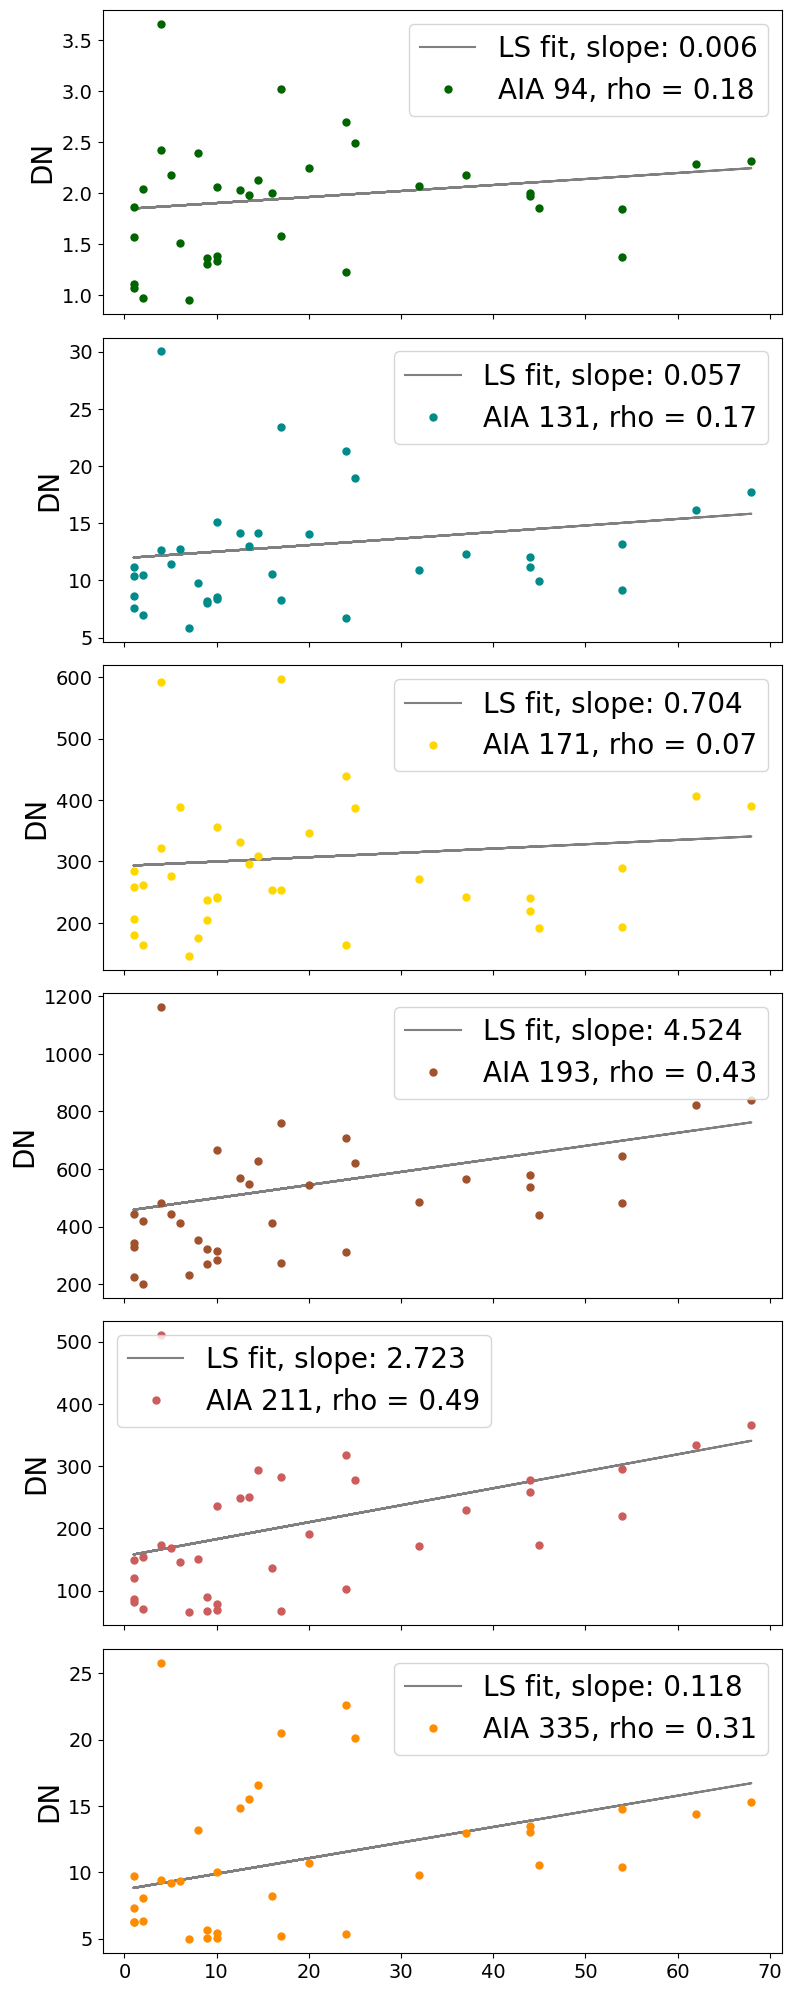

In [123]:
#MEGAPLOT - AREA NORMALIZED
importlib.reload(haa)

from scipy import odr

#ODR documentation: https://docs.scipy.org/doc/scipy-1.16.0/reference/odr.html

def f(B, x):
    #Linear function
    return B[0]*x + B[1]
    
linear = odr.Model(f)

params = ['dn_in']
paramlabels = ['DN']
tcolors = ['darkgreen','darkcyan','gold','sienna','indianred','darkorange']
aiachannels = [94, 131, 171, 193, 211, 335]
skh = [False, False, False, False]


labelsize=20

fig, axes = plt.subplots(6,1, figsize=(8, 20), tight_layout = {'pad': 1}, sharex='col')

for i in range(0, len(params)):

    dataparam, ages, stdvs, sks = haa.get_ages_vs_params(all_targets, param=params[i], return_stdvs=True,
                                                skiphuh=skh[i])

    ageorder = np.argsort(ages[:,0])
    print(ages[:,0][ageorder])
    skorder = [sks[a] for a in ageorder]
    print(skorder)

    for j in range(0,6):
        ax=axes[j]
        
#     yerr_ = stdvs
#     wwy = [1/y for y in yerr_]
    

#     #Plot vs. age
#     ax=axes[i]



#     herr = ages[:,0]-ages[:,1]
#     wwx = [1/y for y in herr]

#     #[print(s) if (s not in sks) else print('') for s in regions]

        rho=round(np.corrcoef(ages[:,0], dataparam[:,j])[0,1],2)
        ax.errorbar(ages[:,0], dataparam[:,j], color=tcolors[j], #yerr=yerr_, xerr=herr, 
                    linestyle='none', marker='o', markersize=5, label='AIA '+str(aiachannels[j])+', rho = '+str(rho))

        #Fit option with y weights only
        m, b = np.polyfit(ages[:,0], dataparam[:,j], 1, w=wwy)
        fity = np.array(ages[:,0])*m + b
        ax.plot(ages[:,0], fity, label='LS fit, slope: '+str(round(m,3)), color='grey')  

#     #Fit option with both weights
#     mydata = odr.Data(ages[:,0], dataparam[:,0], wd=wwx, we=wwy)
#     myodr = odr.ODR(mydata, linear, beta0=[0.,1.]) # how to put beta0 values here
#     myoutput = myodr.run()
#     #myoutput.pprint()
#     m, b = myoutput.beta
#     fity = np.array(ages[:,0])*m + b
#     ax.plot(ages[:,0], fity, label='TLS linear fit, slope: '+str(round(m,3)), color='black')


        if j==6:
            ax.set_xlabel('AR Age (days)', fontsize=labelsize)
        ax.set_ylabel(paramlabels[i], fontsize=labelsize)
        ax.legend(fontsize=labelsize)
        ax.tick_params(axis='both', which='major', labelsize=14) 


plt.savefig('aia_vs_age.png')

In [43]:
from astropy import units as u
((150*u.arcsec*750*(u.km/u.arcsec))**2).to(u.cm**2)

<Quantity 1.265625e+20 cm2>

In [47]:
((150*u.arcsec*750*(u.km/u.arcsec))**2).to(u.cm**2).value

1.265625e+20

In [41]:
# #Big initial reference plot of other stuff vs. age.

# fig, axes = plt.subplots(6,2, figsize=(12, 18), tight_layout = {'pad': 1})


# #Parameter to fetch from the result files, using get_ages_vs_params()
# params = ['above10', 'above7', 'above5', 'spexkT', 
#           'upperpower', 'lowerpower', 'upperpower','lowerpower', 
#          'upperpower2', 'lowerpower2', 'upperpower2', 'lowerpower2']

# ylabels = ['log EM integrated above 10 MK', 'log EM integrated above 7 MK', 'log EM integrated above 5 MK', 
#            'Isothermal Fit T (MK)', 
#            'Upper Power Law Index', 'Lower Power Law Index', 'Upper Power Law Index Fit Error', 'Lower Power Law Index Fit Error',
#           'Upper Power Law Index 2', 'Lower Power Law Index 2', 'Upper Power Law Index 2 Fit Error', 'Lower Power Law Index 2 Fit Error']
           
# tcolors = ['dodgerblue', 'purple', 'gold', 'green', 
#            'pink', 'indianred', 'powderblue', 'orange', 
#            'pink', 'indianred','powderblue', 'orange']

# #Index of parameter output from get_ages_vs_params(). 
# #Differs from 0 when parameter has uncertainty, etc, included + you want to plot that.
# pind = [0, 0, 0, 0, 
#             0, 0, 1, 1,
#             0, 0, 1, 1]

# for i in range(0, len(params)):

#     ax=axes[(i//2),(i%2)]

#     if params[i] != 'spexkT':

#         dataparam, ages = haa.get_ages_vs_params(all_targets, param=params[i])    
#         ax.scatter(ages[:,0], dataparam[:,pind[i]], color=tcolors[i])
#         m, b = np.polyfit(ages[:,0], dataparam[:,pind[i]], 1)
#         fity = ages[:,0]*m + b
#         ax.plot(ages[:,0], fity, linestyle='dotted', color=tcolors[i], label='linear fit, slope: '+str(round(m,3)))
#         ax.legend()
#         ax.set_ylabel(ylabels[i])
#         ax.set_xlabel('AR Age (days)')
